In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# portfolio optimization
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [2]:
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

* Пропишем пути до папок с данными и изображениями.

In [4]:
current_dir = Path.cwd()
print(f"Current path is {current_dir}")
data_dir = Path(*current_dir.parts[0:-1])/'data'
image_dir = Path(*current_dir.parts[0:-1])/'images'
print(f"Current data path is {data_dir}")
print(f"Current image path is {image_dir}")

Current path is C:\Users\Vladimir\Desktop\FMFI_1\Магистерские курсы\Управление портфелем\portfolio_HW\scripts
Current data path is C:\Users\Vladimir\Desktop\FMFI_1\Магистерские курсы\Управление портфелем\portfolio_HW\data
Current image path is C:\Users\Vladimir\Desktop\FMFI_1\Магистерские курсы\Управление портфелем\portfolio_HW\images


### Оглавление

1. [Отбор эмитентов дя портфеля](#imoex10)
2. [Рассчитать матрицы доходностей и ковариационные матрицы для отобранных акций на различные даты](#covmat)
3. [Построить границу эффективных портфелей при условии, что короткие продажи разрешены и не имеют ограничений](#frontier_3)
4.	[Построить границу эффективных портфелей при условии, что короткие продажи разрешены, но доходы от короткой продажи каждой акции не должны превышать 25% от собственных средств (капитала) инвестора](#frontier_4)
5.	[Построить границу эффективных портфелей при условии, что короткие продажи запрещены](#frontier_5)
6.	[Построить границу эффективных портфелей при условии, что в каждую из акций должно быть вложено не менее 2% капитала](#frontier_6)
7.	[Проанализировать динамику изменения границы эффективных портфелей](#frontier_7)
8.	[Выбрать индекс для расчёта исторических и скорректированных $\beta$. Привести обоснование выбора.](#choosebeta)
9.	[Рассчитать ковариационную матрицу для отобранных акций на основе исторических $\beta$ (historical betas), которые оцениваются согласно рыночной модели (market model).](#betacovmat)
10.	[Построить границу эффективных портфелей на основе полученной в п. 8 ковариационной матрицы и проанализировать динамику её изменения.](#betacovmat_results)
11.	Рассчитать ковариационную матрицу для отобранных акций на основе скорректированных β (adjusted betas).
12.	Построить границу эффективных портфелей на основе полученной в п. 10 ковариационной матрицы и проанализировать динамику её изменения.
13.	Сравнить границы эффективных портфелей, рассчитанные различными способами. Привести экономическую интерпретацию полученных результатов.


Этот ноутбук содержит в себе результаты выполнения задания по курсу "Управление портфелем".

### Поиск всех эмитентов, которые когда - либо входили в индекс ММВБ-10. Отбор эмитентов для портфеля и загрузка данных.<a class="anchor" id="imoex10"></a>

* Поскольку в индекс ММВБ-10 регулярно отбираются 10 "лучших" по ряду параметров акций, торгующихся на ММВБ, будем отталкиваться от компаний, вошедших в индекс, при формировании вселенной для инвестирования.
[Данные о ребалансировках индекса и конкретных эмитентах можно скачать на сайте Мосбиржи в соответствующем разделе.](https://www.moex.com/ru/index/MOEX10/constituents/)

Посмотрим, что из себя представляет страница ребалансировок за какой-то год в Эксель-файле.

In [125]:
fpath = data_dir/'stock-index-base-moex10-210318.xlsx'
moex10 = pd.DataFrame(pd.read_excel(fpath, 
                                    engine='openpyxl', 
                                    sheet_name='2010'))
moex10.head()

,Year,Quarter,FirstDate,LastDate,SecID,P_0,K,NumDays,NumTrades,Turnover,NumParticipants
0,2010,1,2010-01-12,2010-04-01,FEES,0.320,3174.8349,65,418551,4.103957e+10,289
1,2010,1,2010-01-12,2010-04-01,GAZP,183.090,3174.8349,65,5426444,9.970023e+11,400
2,2010,1,2010-01-12,2010-04-01,GMKN,4245.020,3174.8349,65,1989564,2.547251e+11,315
3,2010,1,2010-01-12,2010-04-01,HYDR,1.138,3174.8349,65,480948,4.036241e+10,296
4,2010,1,2010-01-12,2010-04-01,LKOH,1694.000,3174.8349,65,2377757,2.695565e+11,350


Мы поняли, что нас интересует SecID. Теперь надо собрать все тикеры со всех листов, начиная с 2010 года.

In [126]:
from functools import reduce

years = [str(x) for x in range(2010, 2022)]
tickers = []

for year in years:
    tickers+=\
        pd.read_excel(fpath, 
                      sheet_name=year, 
                      usecols=['SecID']).values.ravel().tolist()

tickers = [ticker.strip() for ticker in tickers]
list(set(tickers))

['RTKM',
 'VTBR',
 'MTSS',
 'PLZL',
 'ALRS',
 'MOEX',
 'URKA',
 'GMKN',
 'SBER03',
 'MAGN',
 'TATN',
 'SBERP03',
 'AFLT',
 'AFKS',
 'ROSN',
 'YNDX',
 'SNGSP',
 'SBERP',
 'GAZP',
 'TRNFP',
 'LKOH',
 'SBER',
 'MGNT',
 'SNGS',
 'HYDR',
 'MTLR',
 'FEES',
 'POLY',
 'CHMF',
 'NVTK',
 'NLMK']

Единственное, что смущает - это какой-то непонятный SBER03. Выкинем его из списка.

In [127]:
tickers = list(filter(lambda x: x not in ['SBER03', 'SBERP03'], tickers))
unique_tickers = list(set(tickers))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


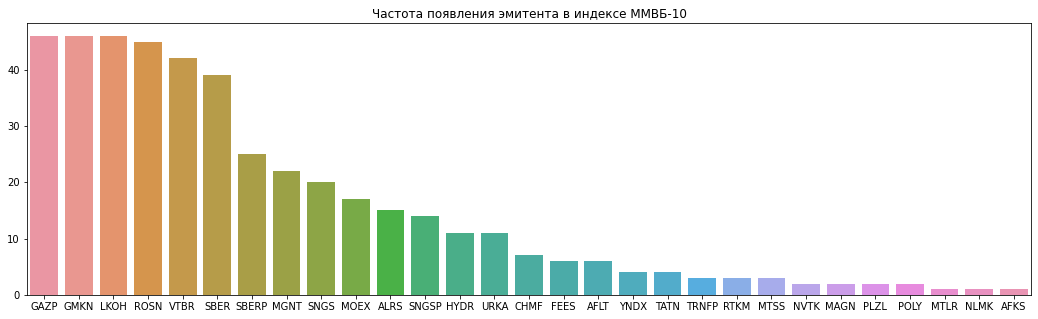

In [128]:
from collections import Counter

countdata = Counter(tickers)
countdata = dict(sorted(countdata.items(), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(18, 5));
sns.barplot(list(countdata.keys()), list(countdata.values()));
plt.title('Частота появления эмитента в индексе ММВБ-10');

plt.savefig(image_dir/'Frequencies of MOEX10 constituents.jpg')

In [129]:
print(f'Всего в нашей выборке оказалось {len(set(tickers))} уникальных эмитентов')

Всего в нашей выборке оказалось 29 уникальных эмитентов


In [130]:
ticker_df = pd.DataFrame({'ticker': list(countdata.keys()),
                          'n_times': list(countdata.values())})
ticker_df.to_csv(data_dir/'imoex10.csv')

При желании, можно выкинуть примерно половину эмитентов - оставить всех, кто не менее 10 раз попадал в индекс, и посчитать портфель для такого "сокращённого состава". Но поскольку задание требует работать не менее чем с 30 эмитентами, придётся оставить всех.

Теперь получим котировки с 2010 по 2021 год с помощью нашего модуля `parser.py`. Он качает данные напрямую по API Мосбиржи - это позволяет надеяться, что цифры, которые мы получим, будут не совсем бессмысленными.

In [131]:
tickers = pd.read_csv(data_dir/'imoex10.csv', usecols=['ticker'])
tickers = tickers.ticker.values.ravel().tolist()

In [132]:
from moexparser import get_historical_data

df = get_historical_data(tickers,
                         start_date = '2010-01-01',
                         end_date = '2021-06-12')
df.head(5)

,GAZP,GMKN,LKOH,ROSN,VTBR,SBER,SBERP,MGNT,SNGS,MOEX,...,TRNFP,RTKM,MTSS,NVTK,MAGN,PLZL,POLY,MTLR,NLMK,AFKS
TRADEDATE,,,,,,,,,,,,,,,,,,,,,
2014-06-09,144.40,7029,2025.0,240.36,0.04731,88.89,73.40,8949.0,26.942,65.66,...,77050,87.69,297.55,405.93,6.835,511.6,314.79,49.7,49.42,44.448
2014-06-10,144.75,6900,2061.4,242.80,0.04700,88.99,73.33,9100.0,27.394,63.88,...,77055,88.80,296.63,401.37,6.762,507.0,316.49,53.2,48.60,45.499
2014-06-11,146.40,6940,2097.9,249.66,0.04698,89.00,73.69,9070.0,27.559,65.65,...,76510,88.06,301.20,400.70,6.770,512.8,314.59,51.4,48.33,45.300
2014-06-16,145.20,6649,2149.0,253.30,0.04643,84.85,69.45,8899.0,27.351,65.65,...,75637,84.30,305.75,407.99,6.848,517.0,324.00,52.0,48.30,45.999
2014-06-17,144.77,6622,2130.0,251.59,0.04680,83.80,67.34,8799.0,27.792,66.30,...,76065,83.22,301.00,408.34,6.857,513.1,311.50,55.5,48.39,46.100


Необходимо почистить выборку: посмотреть, сколько пропусков для каждого из эмитентов, принять решение, выбрасываем мы его или нет.

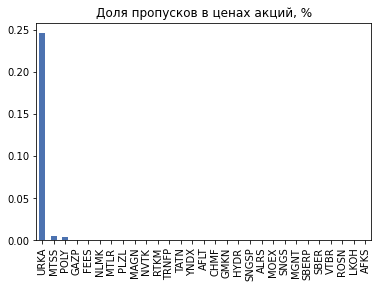

In [133]:
nan_df = {name:round(df[name].isna().sum()/df.shape[0], 3) for name in df.columns}
pd.Series(nan_df).sort_values(ascending=False).plot(kind='bar', title='Доля пропусков в ценах акций, %');

URKA - неликвидный эмитент, его мы можем удалить с чистой совестью. Для оставшихся заполним пропуски предыдущими значениями и проверим, что в выборке не осталось `NaN`.

In [134]:
df = df.drop(columns=['URKA'])
df.fillna(method='ffill', inplace=True)

In [135]:
print(f"В выборке осталось {df.isna().sum().sum()} пропусков.")

В выборке осталось 0 пропусков.


Теперь:
1. Сохраним цены акций в папку data.
2. Сохраним доходности акций в папку data.

In [136]:
df.to_csv(data_dir/'prices.csv')
# рассчитаем лог-доходности, они обладают приятными свойствами
log_rets = np.log(1+df.pct_change().iloc[1:, ])
log_rets.to_csv(data_dir/'log_returns.csv')

### 2. Рассчитать матрицы доходностей и ковариационные матрицы для отобранных акций на различные даты.<a class="anchor" id="covmat"></a>

Для начала неплохо бы посмотреть на данные: какая динамика у цен акций и доходностей, какая у них волатильность, посчитать какие-то выборочные характеристики.

In [5]:
prices = pd.read_csv(data_dir/'prices.csv',
                    header=0,
                    index_col=0,
                    parse_dates=True)

rets = np.log(1+prices.pct_change().iloc[1:, ])

Поскольку цены акций эмитентов совершенно разные, смотреть на них не имеет смысла. Точно так же и график доходностей не несёт много смысла, разве что можно увидеть всплески волатильности:

In [138]:
plt.rcParams.update({'font.size': 18});

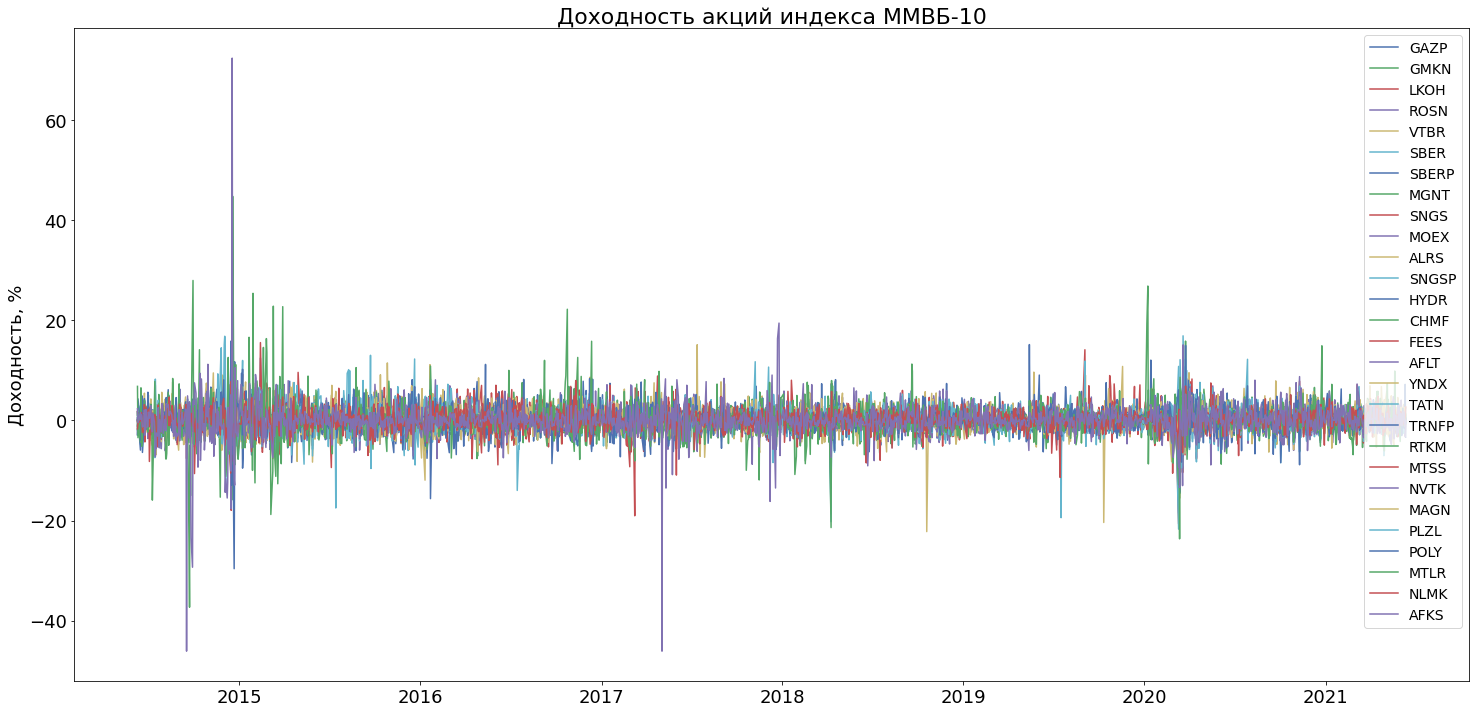

In [139]:
fig, ax = plt.subplots(figsize=(25, 12));

for ticker in rets.columns.tolist():
    ax.plot(rets.index,
             rets[ticker].values*100,
             label=str(ticker));
    
ax.legend(loc='upper right', fontsize=14);
ax.set_title('Доходность акций индекса ММВБ-10', fontsize=22);
ax.set_ylabel('Доходность, %');    

plt.savefig(image_dir/'Returns of stocks.jpg');

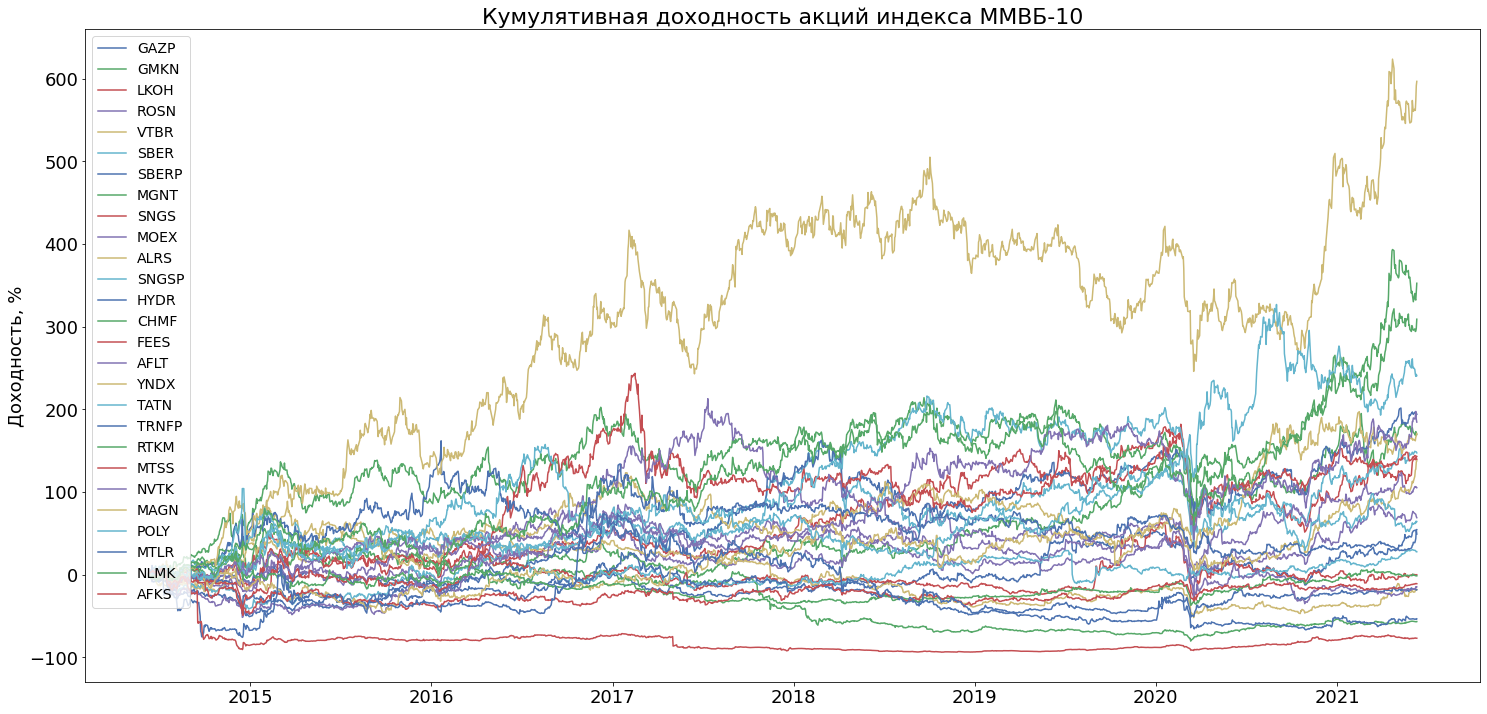

In [140]:
fig, ax = plt.subplots(figsize=(25, 12))

for ticker in rets.drop(columns=['PLZL']).columns.tolist():
    ax.plot(rets.index,
             (np.cumprod(rets[ticker].values+1)-1)*100,
             label=str(ticker));
    
ax.legend(loc='upper left', fontsize=14);
ax.set_title('Кумулятивная доходность акций индекса ММВБ-10', fontsize=22);
ax.set_ylabel('Доходность, %');    

plt.savefig(image_dir/'Cumulative returns of stocks.jpg');

На прошлом графике мы не нарисовали "Полюс Золото", поскольку его акции выросли гораздо больше всего рынка:

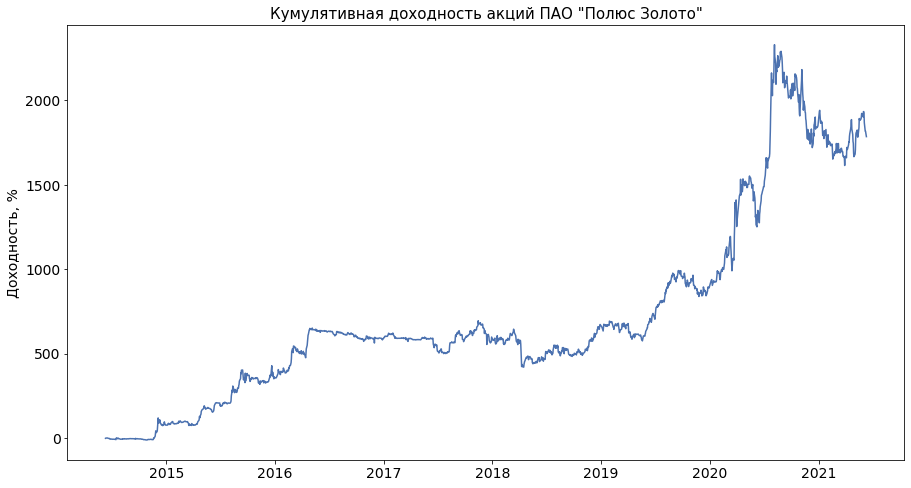

In [141]:
plt.rcParams.update({'font.size': 14});
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(rets.PLZL.index, (np.cumprod(rets.PLZL.values+1)-1)*100);

ax.set_title('Кумулятивная доходность акций ПАО "Полюс Золото"', fontsize=15);
ax.set_ylabel('Доходность, %');    

plt.savefig(image_dir/'Cumulative returns of PLZL.jpg');

Но график с кумулятивной доходностью, если честно, не очень понятный. Проще посмотреть на таблицу или столбчатый график:

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


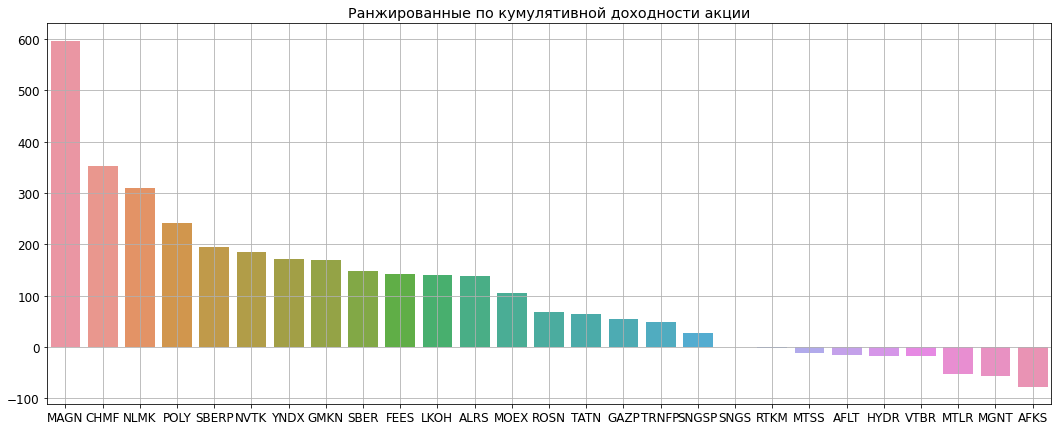

In [142]:
plt.rcParams.update({'font.size': 12});

cumulative_rets = (((rets.drop(columns=['PLZL'])+1).cumprod()-1)*100).iloc[-1, :].sort_values(ascending=False)

plt.figure(figsize=(18, 7));
plt.title('Ранжированные по кумулятивной доходности акции');
sns.barplot(cumulative_rets.index.values.tolist(), cumulative_rets.values.tolist());
plt.grid(True);
plt.savefig(image_dir/'Sorted cumulative returns of stocks.jpg');

Аналогично поступим со стандартными отклонениями акций:

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


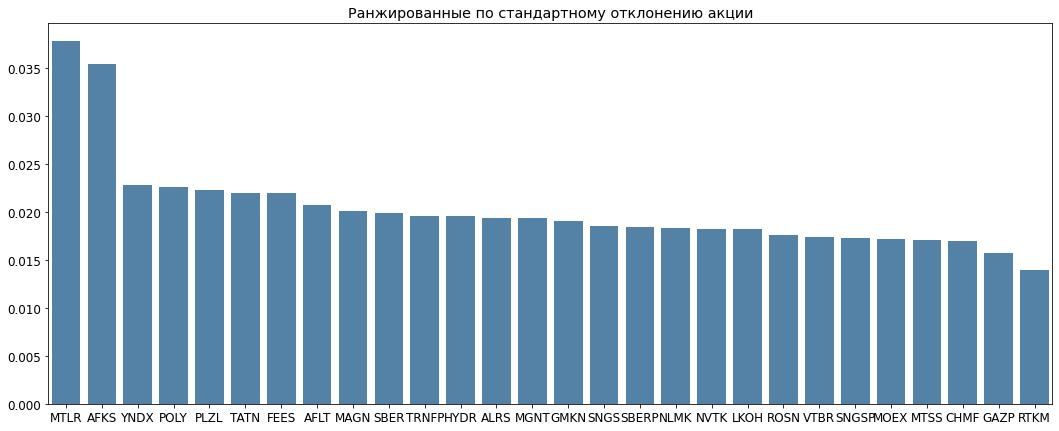

In [143]:
std_data = rets.std().sort_values(ascending=False)

plt.figure(figsize=(18, 7));
plt.title('Ранжированные по стандартному отклонению акции');
sns.barplot(std_data.index.values.tolist(), std_data.values.tolist(), color='steelblue');
plt.savefig(image_dir/'Sorted standard deviations of stocks.jpg');

**Ожидаемая доходность**

In [144]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import plotting

In [145]:
mu = mean_historical_return(prices)
S = risk_models.sample_cov(prices)

<AxesSubplot:>

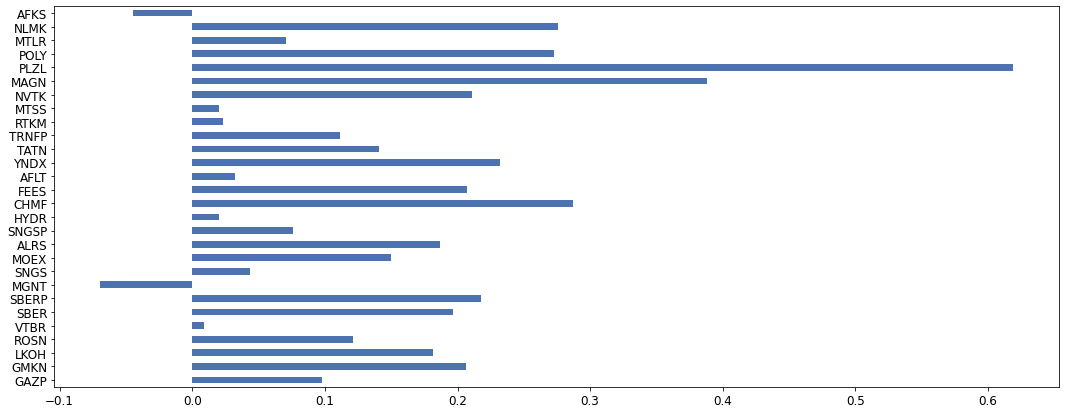

In [146]:
mu.plot.barh(figsize=(18,7))

<AxesSubplot:>

<Figure size 1296x504 with 0 Axes>

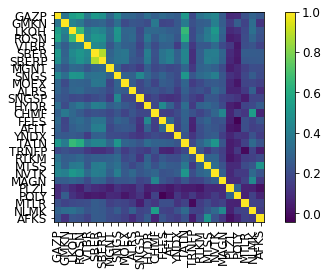

In [147]:
plt.figure(figsize=(18,7))
plotting.plot_covariance(S, plot_correlation=True)

Ожидаемая доходность и ковариационная матрица на различные даты

In [148]:
prices.index

DatetimeIndex(['2014-06-09', '2014-06-10', '2014-06-11', '2014-06-16',
               '2014-06-17', '2014-06-18', '2014-06-19', '2014-06-20',
               '2014-06-23', '2014-06-24',
               ...
               '2021-05-31', '2021-06-01', '2021-06-02', '2021-06-03',
               '2021-06-04', '2021-06-07', '2021-06-08', '2021-06-09',
               '2021-06-10', '2021-06-11'],
              dtype='datetime64[ns]', name='TRADEDATE', length=1766, freq=None)

Отбираем даты - поквартально с 2014-06-09 по 2021-06-11

In [149]:
dates = pd.date_range(start = '2014-06-09', end='2021-06-11', freq='Q')

In [150]:
dates

DatetimeIndex(['2014-06-30', '2014-09-30', '2014-12-31', '2015-03-31',
               '2015-06-30', '2015-09-30', '2015-12-31', '2016-03-31',
               '2016-06-30', '2016-09-30', '2016-12-31', '2017-03-31',
               '2017-06-30', '2017-09-30', '2017-12-31', '2018-03-31',
               '2018-06-30', '2018-09-30', '2018-12-31', '2019-03-31',
               '2019-06-30', '2019-09-30', '2019-12-31', '2020-03-31',
               '2020-06-30', '2020-09-30', '2020-12-31', '2021-03-31'],
              dtype='datetime64[ns]', freq='Q-DEC')

In [57]:
# Матрицы доходностей и ковариационные матрицы для отобранных акций на различные даты

ret = []
cov = []

for i in dates:
    period_prices = prices[prices.index < i]
    mu = mean_historical_return(period_prices)
    S = risk_models.sample_cov(period_prices)
    ret.append(mu)
    cov.append(S)

In [108]:
dates_y = pd.date_range(start = '2014-06-09', end='2021-06-11', freq='Y')

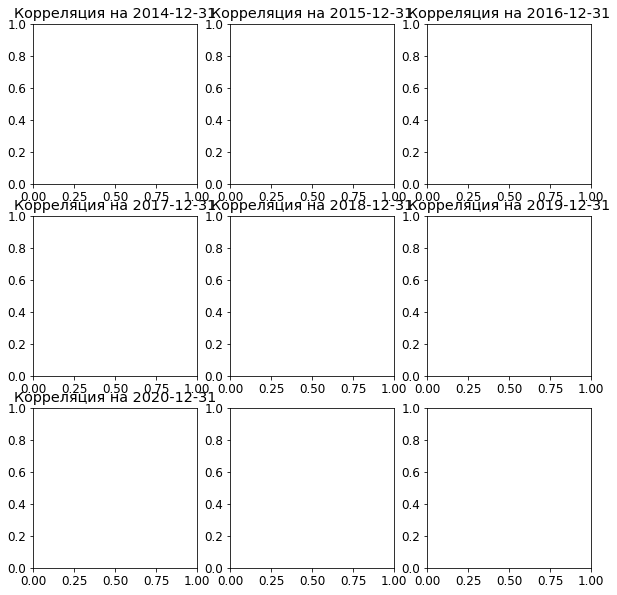

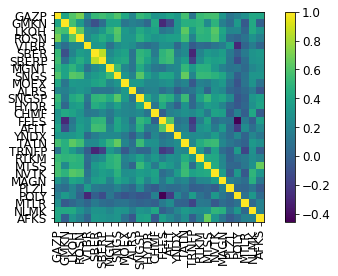

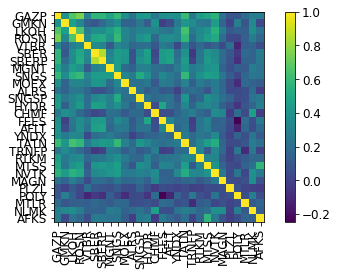

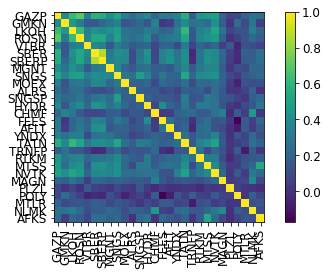

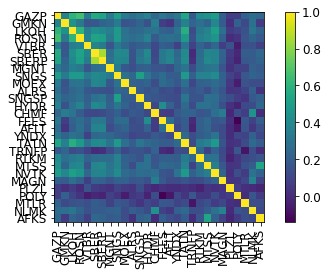

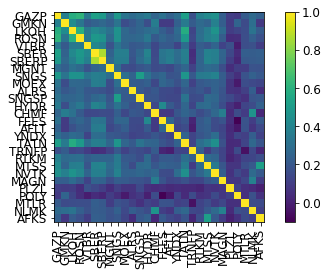

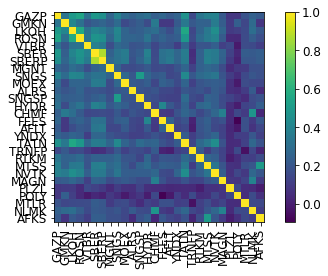

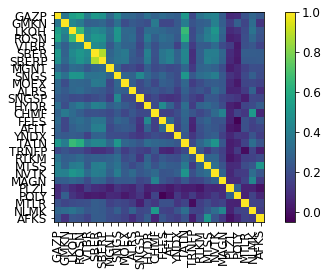

In [168]:

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10));
for i, date in enumerate(dates_y):
    period_prices = prices[prices.index < date]
    mu = mean_historical_return(period_prices)
    S = risk_models.sample_cov(period_prices)
    
    axs[i//3, i%3].set_title(f"Корреляция на {date.date()}");
    plotting.plot_covariance(S, plot_correlation=True, ax=axs[i//3, i%3]);
 

### 3. Построить границу эффективных портфелей при условии, что короткие продажи разрешены и не имеют ограничений <a class="anchor" id="frontier_3"></a>

In [106]:
from pypfopt import EfficientFrontier, objective_functions

In [109]:
# зафиксируем даты (ежегодно)
dates_y

DatetimeIndex(['2014-12-31', '2015-12-31', '2016-12-31', '2017-12-31',
               '2018-12-31', '2019-12-31', '2020-12-31'],
              dtype='datetime64[ns]', freq='A-DEC')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/cvxpy/problems/problem.py:1278: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/cvxpy/problems/problem.py:1278: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/cvxpy/problems/problem.py:1278: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/cvxpy/problems/problem.py:1278: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver sett

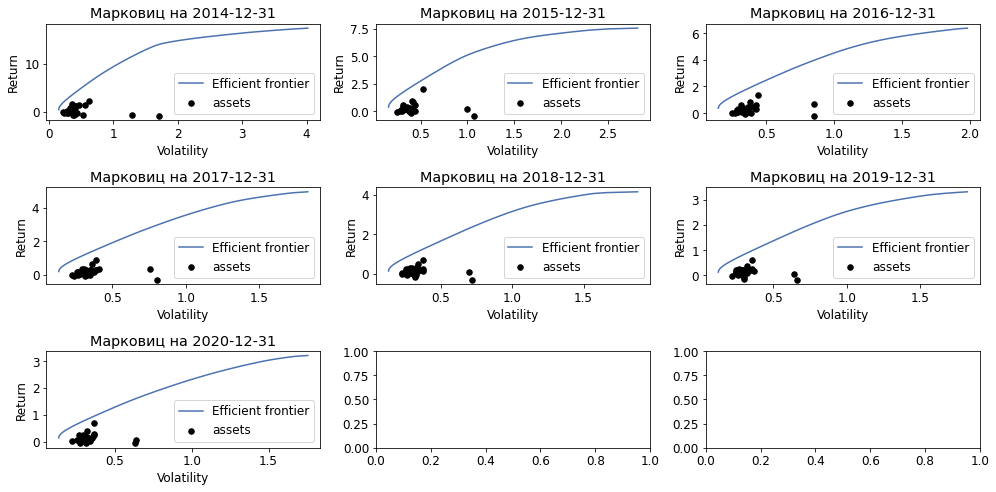

In [160]:
from pypfopt import plotting

dates_y = pd.date_range(start = '2014-06-09', end='2021-01-01', freq='Y')
# так как в выборке маловато наблюдений, заменим первую дату
dates_y

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(14, 7));

# короткие продажи разрешены и не имеют ограничений

for i, date in enumerate(dates_y):
    
    period_prices = prices[prices.index<date]
    
    # считаем обычный портфель Марковица
    mu = expected_returns.mean_historical_return(period_prices)
    S = risk_models.sample_cov(period_prices)
    ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
        
    axs[i//3, i%3].set_title(f"Марковиц на {date.date()}");
        
        
    plotting.plot_efficient_frontier(ef, 
                                         show_assets=True, 
                                         ax=axs[i//3, i%3]);
        
#plt.savefig(image_dir/'Markowitz portfolios.jpg', dpi=600, bbox_inches='tight');      

### 4. Построить границу эффективных портфелей при условии, что короткие продажи разрешены, но доходы от короткой продажи каждой акции не должны превышать 25% от собственных средств (капитала) инвестора <a class="anchor" id="frontier_4"></a>

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/cvxpy/problems/problem.py:1278: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


SolverError: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.

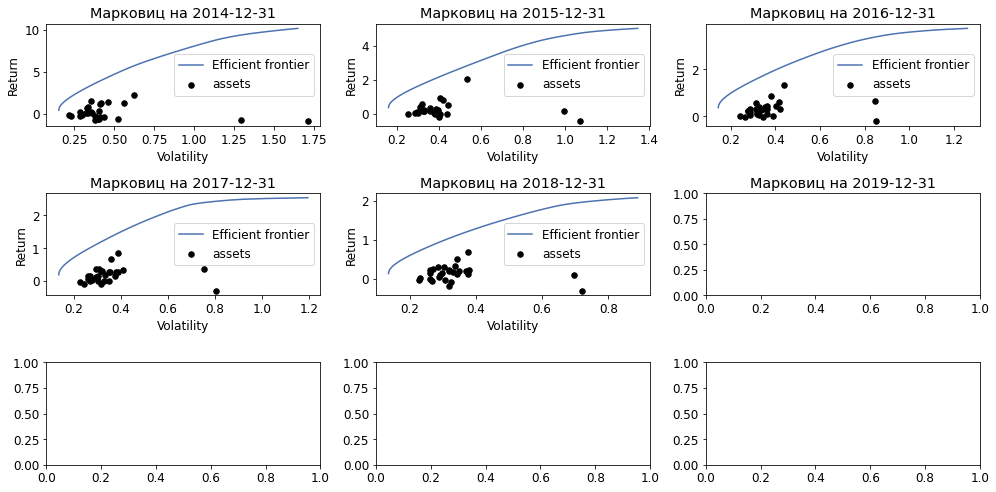

In [161]:
# короткие продажи разрешены, но доходы от короткой продажи каждой акции 
# не должны превышать 25% от собственных средств (капитала) инвестора

dates_y = pd.date_range(start = '2014-06-09', end='2021-01-01', freq='Y')
# так как в выборке маловато наблюдений, заменим первую дату
dates_y

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(14, 7));

# короткие продажи разрешены и не имеют ограничений

for i, date in enumerate(dates_y):
    
    period_prices = prices[prices.index<date]
    
    # считаем обычный портфель Марковица
    mu = expected_returns.mean_historical_return(period_prices)
    S = risk_models.sample_cov(period_prices)
    ef = EfficientFrontier(mu, S, weight_bounds=(-0.25, 1))
        
    axs[i//3, i%3].set_title(f"Марковиц на {date.date()}");
        
        
    plotting.plot_efficient_frontier(ef, 
                                         show_assets=True, 
                                         ax=axs[i//3, i%3]);
        
#plt.savefig(image_dir/'Markowitz portfolios.jpg', dpi=600, bbox_inches='tight');      

### 5. Построить границу эффективных портфелей при условии, что запрещены короткие продажи <a class="anchor" id="frontier_5"></a>

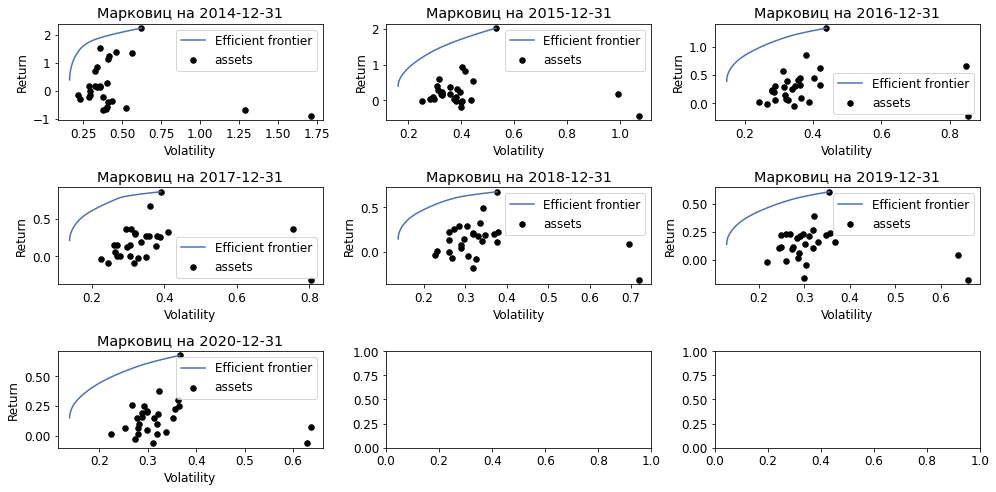

In [162]:
# запрещены короткие продажи

dates_y = pd.date_range(start = '2014-06-09', end='2021-01-01', freq='Y')
# так как в выборке маловато наблюдений, заменим первую дату
dates_y

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(14, 7));


for i, date in enumerate(dates_y):
    
    period_prices = prices[prices.index<date]
    
    # считаем обычный портфель Марковица
    mu = expected_returns.mean_historical_return(period_prices)
    S = risk_models.sample_cov(period_prices)
    ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
        
    axs[i//3, i%3].set_title(f"Марковиц на {date.date()}");
        
        
    plotting.plot_efficient_frontier(ef, 
                                         show_assets=True, 
                                         ax=axs[i//3, i%3]);
        
#plt.savefig(image_dir/'Markowitz portfolios.jpg', dpi=600, bbox_inches='tight');      

### 6. Построить границу эффективных портфелей при условии, что в каждую из акций должно быть вложено не менее 2% капитала <a class="anchor" id="frontier_6"></a>

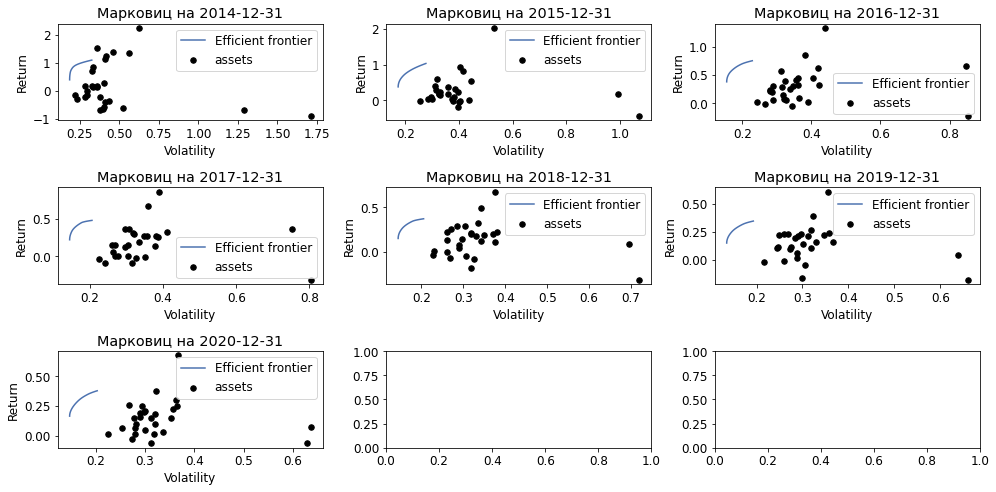

In [163]:
# запрещены короткие продажи

dates_y = pd.date_range(start = '2014-06-09', end='2021-01-01', freq='Y')
# так как в выборке маловато наблюдений, заменим первую дату
dates_y

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(14, 7));


for i, date in enumerate(dates_y):
    
    period_prices = prices[prices.index<date]

    
    # считаем обычный портфель Марковица
    mu = expected_returns.mean_historical_return(period_prices)
    S = risk_models.sample_cov(period_prices)
    ef = EfficientFrontier(mu, S, weight_bounds=(0.02, 1))
        
    axs[i//3, i%3].set_title(f"Марковиц на {date.date()}");
        
        
    plotting.plot_efficient_frontier(ef, 
                                         show_assets=True, 
                                         ax=axs[i//3, i%3]);
        
#plt.savefig(image_dir/'Markowitz portfolios.jpg', dpi=600, bbox_inches='tight');      

### 7. Проанализировать динамику изменения границы эффективных портфелей <a class="anchor" id="frontier_7"></a>

Будем анализировать динамику изменения эффективной границы, построенной при условии запрета коротких продаж, остальное без ограничений.

Изобразим ее еще раз: выберем расширяющееся окно, каждые полгода в выборку будут добавляться новые данные.
Выбранные параметры окна позволят заметить общие тенденции без особых отклонений на шоковые периоды, поскольку в каждой последующей выборке даннных становится все больше и вес аномальных доходностей снижается, однако они не игнорируются полностью.

In [170]:
import warnings
warnings.filterwarnings("ignore")

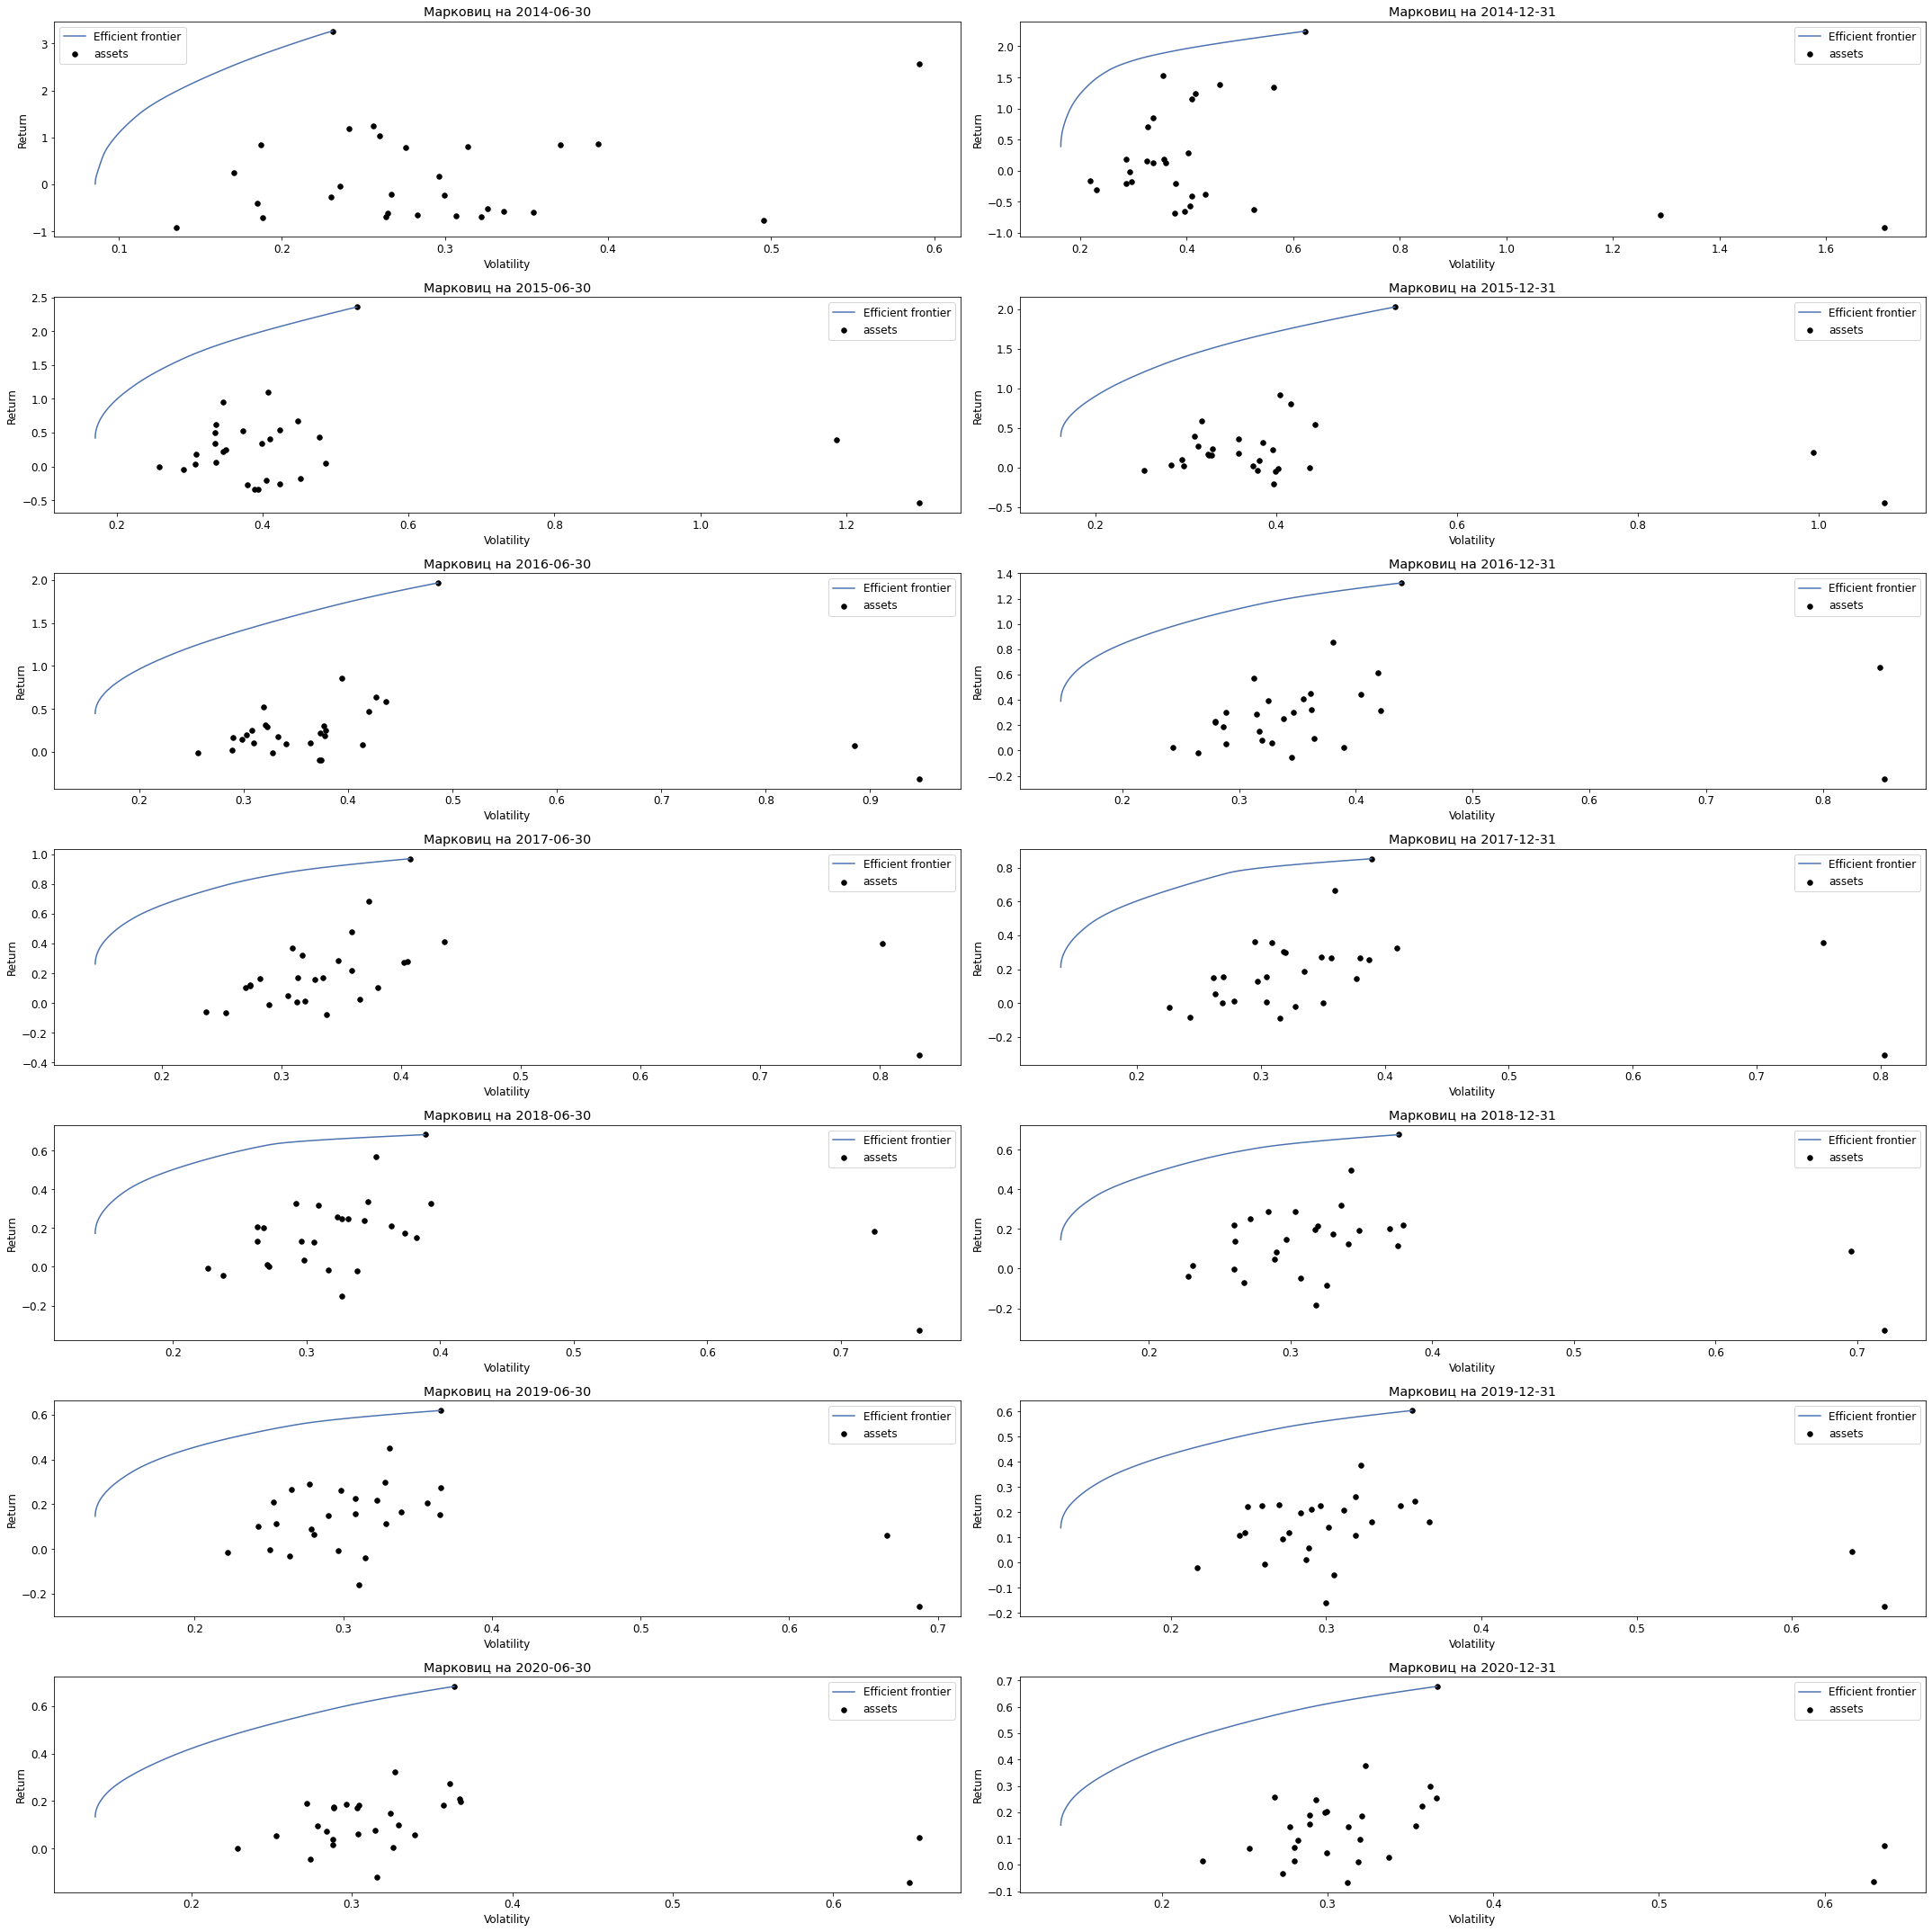

In [194]:
dates_q = pd.date_range(start = '2014-06-09', end='2021-01-01', freq='2Q')
# так как в выборке маловато наблюдений, заменим первую дату
dates_q

fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(30, 30));


for i, date in enumerate(dates_q):
    
    period_prices = prices[prices.index<date]

    
    # считаем обычный портфель Марковица
    mu = expected_returns.mean_historical_return(period_prices)
    S = risk_models.sample_cov(period_prices)
    ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
        
    axs[i//2, i%2].set_title(f"Марковиц на {date.date()}");
        
        
    plotting.plot_efficient_frontier(ef, 
                                         show_assets=True, 
                                         ax=axs[i//2, i%2]);
        
plt.savefig(image_dir/'7_compare_frontier_1.jpg', dpi=600, bbox_inches='tight');        

Каждому ряд графиков соответствует определенному году с 2014 по 2019 с интервалом в 6 месяцев.
Иcходя из диапазона значений оси ординат, можно заметить снижение доходности эффективных портфелей.
Посмотрим более детально на общем графике.

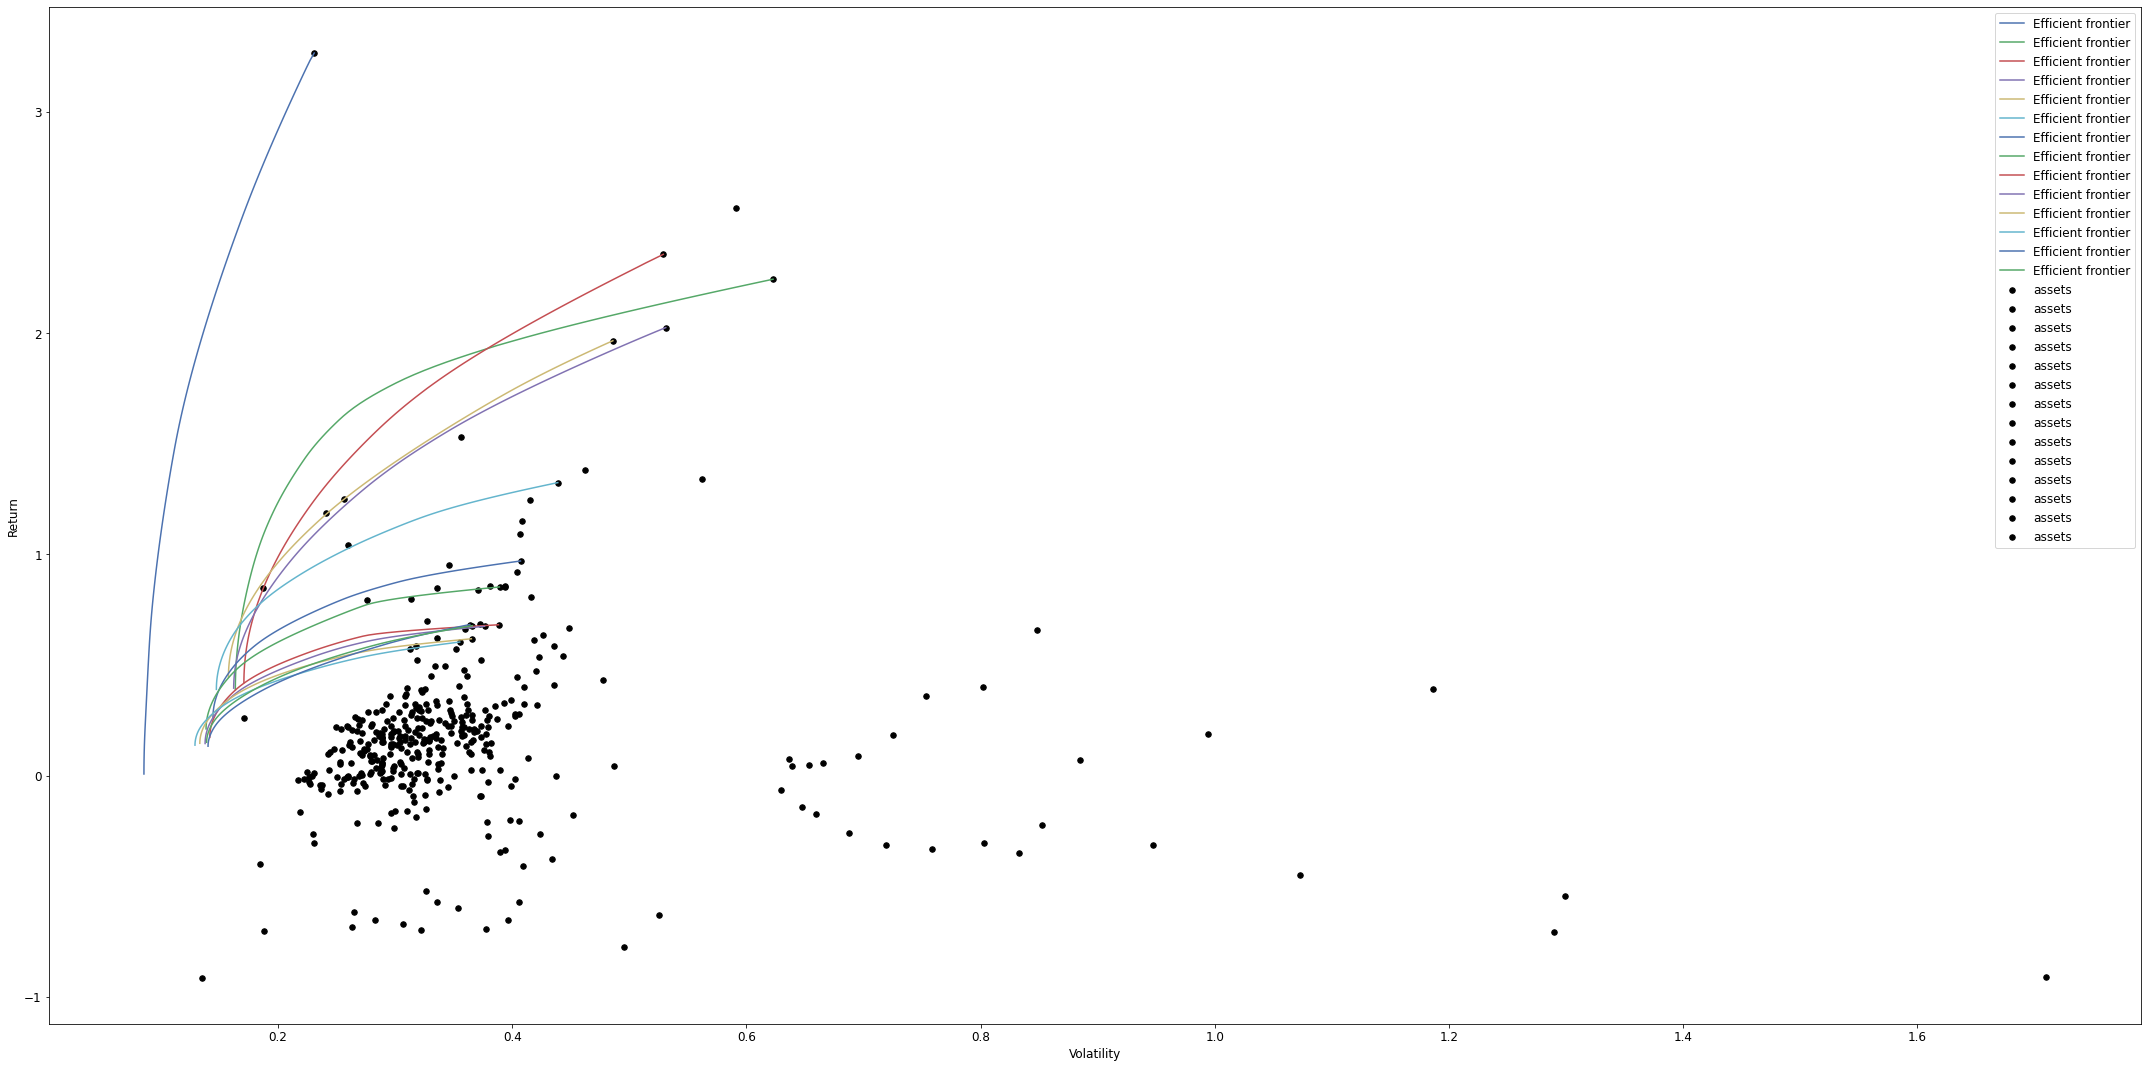

<Figure size 432x288 with 0 Axes>

In [195]:
dates_q = pd.date_range(start = '2014-06-09', end='2021-01-01', freq='2Q')
# так как в выборке маловато наблюдений, заменим первую дату
dates_q

fig  = plt.figure(figsize=(30, 15))


for i, date in enumerate(dates_q):
    
    period_prices = prices[prices.index<date]

    
    # считаем обычный портфель Марковица
    mu = expected_returns.mean_historical_return(period_prices)
    S = risk_models.sample_cov(period_prices)
    ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
        
    plotting.plot_efficient_frontier(ef, show_assets=True, label = (f"Марковиц на {date.date()}"))

plt.legend()
plt.show()
        
plt.savefig(image_dir/'7_compare_frontier_2.jpg', dpi=600, bbox_inches='tight');      

По мере роста окна точки соответствующие активам сгущаются.
Как и сама эффективная граница, перемещающаяся ниже.
Можно предположить, что данная динамика связана с отдалением от кризисного периода 2014-2015 года.
В связи с санкциями против РФ и общим уровнем колебания на финансовых рынках, первые наблюдения более волатильны и так как наше окно начинается как раз с кризисного периода, полученный результат ожидаем.

Сначала сдвиг границы происходит в более широком диапазоне, постепенно уменьшая шаг.
С учетом последних периодов изменения едва заметны, форма границы визуально не сильно меняется.

### 8.	Выбрать индекс для расчёта исторических и скорректированных β. Привести обоснование выбора. <a class="anchor" id="choosebeta"></a>

Собственно выбор у нас невелик - на российском рынке не так много индексов. Индекс ММВБ10, от которого мы отталкивались при выборе эмитентов, не слишком рапространён. Наиболее известный индекс, который считается в определённой степени "прокси" на динамику российского рынка акций - индекс ММВБ (IMOEX). Его мы и будем использовать при расчёте беты.

Для начала хорошо бы получить данные по индексу. У нас два варианта: попробовать по API ММВБ, но может не выйти - парсер, написанный нами, предназначен для акций; или выкачать котировки закрытия из Bloomberg/Thomson Reuters.

In [6]:
from moexparser import get_historical_data

try:
    moex = get_historical_data(['IMOEX'],
                           start_date='2010-01-01',
                           end_date='2021-06-12')
except ValueError as e:
    print('Через наш парсер нельзя получить исторические данные по индексу. \n',e)

Через наш парсер нельзя получить исторические данные по индексу. 
 Тикер, который вы ввели, не торгуется в основном режиме (T+) на ММВБ.Либо вы неправильно ввели тикер, либо измените режим торгов!


Тогда получим данные из Thomson Reuters, заодно сразу выкачаем данные для ММВБ10 - они нам могут пригодиться. При загрузке данных проверил, что они совпадают с цифрами на сайте ММВБ.

In [8]:
index_path = data_dir/'indexes.csv'
index_p = pd.read_csv(index_path,
                      header=0,
                      index_col=0,
                      parse_dates=True)

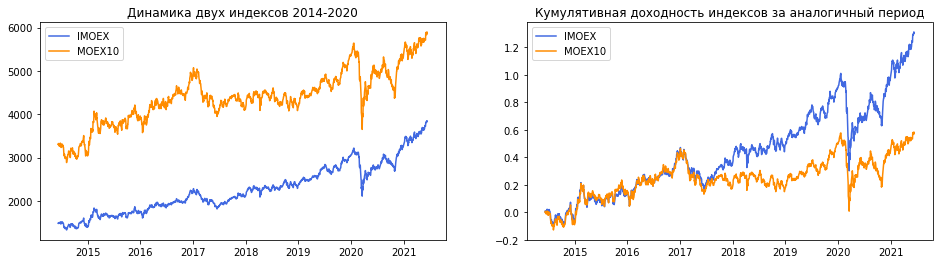

In [18]:
index_rets = np.log(1+index_p.pct_change()).iloc[1:]
cumulative_rets = (index_rets+1).cumprod()-1

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 4));

ax1.plot(index_p.IMOEX, label='IMOEX', color='royalblue');
ax1.plot(index_p.MOEX10, label='MOEX10', color='darkorange');
ax1.set_title('Динамика двух индексов 2014-2020');
ax1.legend(loc='upper left');

ax2.plot(cumulative_rets.IMOEX, label='IMOEX', color='royalblue');
ax2.plot(cumulative_rets.MOEX10, label='MOEX10', color='darkorange');
ax2.set_title('Кумулятивная доходность индексов за аналогичный период');
ax2.legend(loc='upper left');

То ли у индекса ММВБ10 методика отбора эмитентов неудачная, то ли дело действительно в более широком наборе эмитентов в ММВБ (вот она, родимая диверсификация) и в том, что настоящий value может быть спрятан в акциях второго эшелона. При этом ММВБ ещё и сопоставим по волатильности:

Соотношение волатильности ММВБ к ММВБ10 составляет 0.9691169943514203


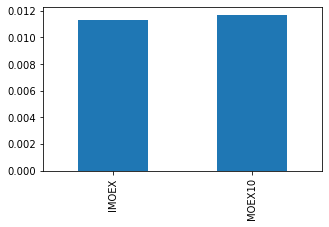

In [19]:
print(f"Соотношение волатильности ММВБ к ММВБ10 составляет {index_rets.IMOEX.std()/index_rets.MOEX10.std()}")
index_rets.std().plot(kind='bar', figsize=(5, 3));

Возможно, вышло так, что в выгрузке по API Мосбиржи есть даты, которых нет в выгрузке из Thomson Reuters, и наоборот. Нам хотелось бы этого избежать, ведь мы по данным индекса будем рассчитывать беты для отдельных акций.

In [20]:
indexes = pd.merge(prices.GAZP, index_p, 
                   how='left',
                   right_index=True,
                   left_index=True)
indexes.drop(columns=['GAZP'], inplace=True)
indexes.fillna(method='ffill', inplace=True)
indexes.to_csv(data_dir/'clean_index_prices.csv')

indexes = np.log(1+indexes.pct_change()).iloc[1:, ]
indexes.to_csv(data_dir/'clean_index_rets.csv')

## 9.	Рассчитать ковариационную матрицу для отобранных акций на основе исторических β (historical betas), которые оцениваются согласно рыночной модели (market model). <a class="anchor" id="betacovmat"></a>

Теперь, когда мы сохранили данные в нормальном виде, можно их заново прочитать (чтобы в дальнейшем при моделировании не заморачиваться каждый раз с запуском ячеек выше для предобработки котировок индекса).

In [6]:
indexes = pd.read_csv(data_dir/'clean_index_rets.csv',
                      header=0,
                      index_col=0,
                      parse_dates=True)
indexes.head(5)

,IMOEX,MOEX10
TRADEDATE,,
2014-06-10,0.003642,-0.000703
2014-06-11,0.006932,0.007947
2014-06-16,-0.004841,-0.011647
2014-06-17,-0.005067,-0.007176
2014-06-18,0.005301,0.006549


Для начала посмотрим на корреляцию между индексами и теми эмитентами, которые есть в выборке. Очевидно, что это лишь грубая оценка и корреляции существенно меняются во времени.

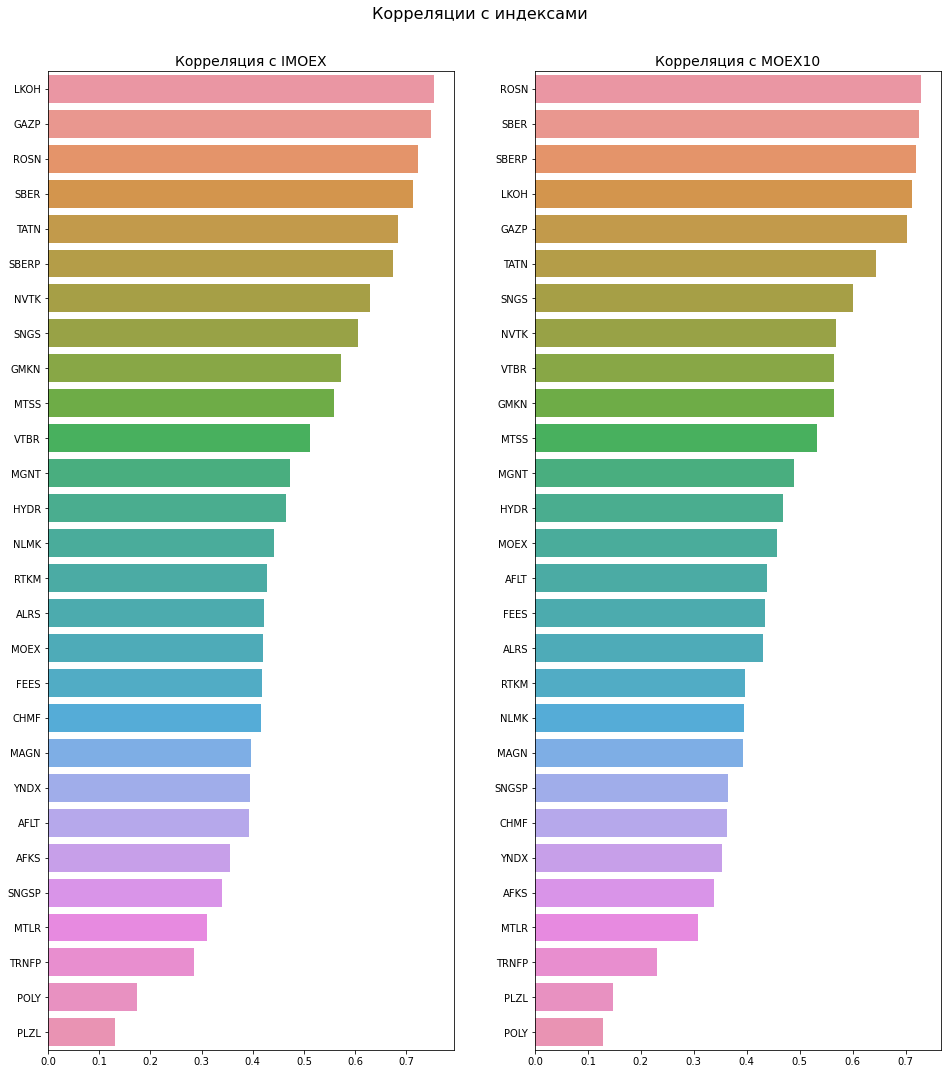

In [22]:
imoex_corr = rets.corrwith(indexes.IMOEX).sort_values(ascending=False)
moex10_corr = rets.corrwith(indexes.MOEX10).sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 18))

sns.barplot(y=imoex_corr.index.values.tolist(),
            x=imoex_corr.values.tolist(),
            ax=ax1);
ax1.set_title('Корреляция с IMOEX', fontsize=14);

sns.barplot(y=moex10_corr.index.values.tolist(),
            x=moex10_corr.values.tolist(),
            ax=ax2);
ax2.set_title('Корреляция с MOEX10', fontsize=14);

fig.suptitle('Корреляции с индексами', fontsize=16, y=0.93);
plt.savefig(image_dir/'Correlations with index.jpg', dpi=600, bbox_inches='tight');

В общем-то, ничего особенно удивительного мы не увидели. 
1. Наиболее связаны с индексом нефтяники и газовики, поскольку они в среднем исторически имеют наибольшую капитализацию и ликвидность на ММВБ, а значит, и наибольшие веса в индексе ММВБ - именно он интересует нас в первую очередь. 
2. Металлурги (кроме золотодобытчиков) находятся где-то посередине и по капитализации с ликвидностью, и по весам в индексе.
3. Золотодобытчики находятся в хвосте, поскольку золото - традиционно защитный актив, и котировки компаний, связанных с ним, должны двигаться в направлении, противоположном всему остальному рынку; но поскольку у "Полюс Золота" и "Полиметалла" неплохая капитализация и они с приличными весами входят в индекс ММВБ, корреляция мала и положительна.

В общем и целом, корреляция пропорциональна весам эмитентов в индексе ММВБ.

**Теперь перейдём непосредственно к оценке ковариационных матриц с помощью коэффициента $\beta$.**
Что мы хотим? 
* Оценивать бету по выборке и возвращать оценённые значения доходности актива, а также саму бету
  - иметь возможность подставлять в уравнение константу или нет
* Иметь возможность параллельной оценки бет
* Оценивать ковариационную матрицу на основе очищенной доходности
* В идеале, выбрать оптимальный период, на котором надо оценивать и усреднять беты. 
 - Для оценки нужная целевая метрика ошибки. Baseline - MSE. Возможно, стоит над другой подумать? (MSE слишком большой вес придаёт выбросам, а они в выборке есть в период кризиса). На Kaggle вроде были другие метрики на соревнованиях, связанных с трейдингом?

Класс для усреднения бет. 

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from itertools import product, repeat
from datetime import datetime


class AverageBeta:
    
    def __init__(self, asset: pd.Series, index: pd.Series, 
                 agg_period: int, window: int):
        """
        --------------------
        asset: asset returns
        index: index returns the same shape as asset returns
        agg_period: how many daily observations to use to calculate mean beta
        window: how many observations to use in train sample
        --------------------
        """
        if asset.shape[0]-1-agg_period-window < 0:
            raise ValueError(f""" Размер тренировочной выборки: {window}.
                                   Самый большой лаг: {agg_period}.
                                   В выборке {asset.shape[0]} наблюдений.
                                   Для оценки модели {agg_period} периодов назад не хватает данных.
                                   Измените размер тренировочной выборки или глубину лага.""")

        self.agg_period = agg_period
        self.window = window
        self.asset = asset
        self.index = index
        self.betas = dict()
        self.R2 = dict()
        self.RMSE = dict()

    def fit(self):
        """ Calculates betas """
        # оценим циклом линейные регрессии на разных подвыборках
        for i in range(self.agg_period):

            # оценим модель
            start = self.asset.shape[0]-1-i-self.window
            stop = self.asset.shape[0]-1-i
            asset_subset = self.asset.iloc[start:stop]
            index_subset = self.index.iloc[start:stop]

            X, y = index_subset.values.reshape(-1, 1), asset_subset.values
            model = LinearRegression(fit_intercept=False)
            model.fit(X, y)

            # сохраним метрики качества и коэффиценты
            # номер модели - последняя дата, которая есть в тренировочной выборке модели
            j = asset_subset.index[-1].date().strftime('%Y-%m-%d')
            self.betas[j] = model.coef_[0]
            self.R2[j] = r2_score(y, model.predict(X))
            self.RMSE[j] = mean_squared_error(y, model.predict(X))**(1/2)

        # ради чего все усилия
        self.average_beta = pd.Series(self.betas).mean()
        self.median_beta = pd.Series(self.betas).median()

3. И теперь та-даам, класс непосредственно для оценки ковариационной матрицы доходностей с помощью усреднённых (или не усреднённых) бет - тут уж как душа пользователя пожелает. В нашем классе c помощью метода **fit()** мы можем:


   1. Хранить и получить характеристики каждого отдельного уравнения (ошибку на train, $R^2$).
   2. Оценивать любое нужное нам количество бет на исторических данных с помощью аргумента **agg_period** (например, можно взять 60 последних бет при agg_period = 60, то есть создастся 60 выборок для оценивания, каждая из которых будет сдвинута на день назад относительно предыдущей выборки).
   3. Оценивать регрессионное уравнение для бет на выборках с любым количеством наблюдений с помощью параметра **window** (например, window = 126 означает, что каждую из регрессий мы оцениваем на 126 наблюдениях).
   5. Для каждого актива в объекте класса сохраняются все беты и их метрики:
      * Посмотреть на беты актива можно в атрибуте **betas**.
      * Средние беты активов хранятся в атрибуте **average_betas**.
      * Медианные беты, соответственно - в атрибуте **median_betas**.
   6. Самое главное, ради чего всё затевалось - после применения метода **fit()** к объекту класса `BetaCov` (в результате применения метода как раз оцениваются модели) мы можем получить из объекта класса атрибут **median_vcov**  или **mean_vcov** (ковариационную матрицу, оценённую с помощью бет). Мы можем усреднять беты по-разному - это и отражено в названии ковариационных матриц.

Также при желании мы можем вытащить по атрибутам `average_beta_rets`, `median_beta_rets` оценки доходностей, полученные с помощью бет.

Всё это звучит довольно страшно, но на примерах будет понятней.

In [76]:
class BetaCov:
    """
    Returns covariance matrix of returns fitted with market model
    and characteristics of market model regressions
    """

    def __init__(self, data: pd.DataFrame, index: pd.Series):
        """
        data: asset returns
        index: index to estimate market model
        """
        self.data = data
        self.index = index
        # сохраним оценки доходностей, полученные из market model
        # оценки доходностей по средней бете
        self.average_beta_rets = pd.DataFrame(
            data=None, columns=self.data.columns)
        # оценки доходностей по медианной бете
        self.median_beta_rets = self.average_beta_rets.copy()
        self.betas = self.average_beta_rets.copy()
        self.R2 = self.betas.copy()
        self.RMSE = self.betas.copy()
        self.mean_vcov, self.median_vcov = None, None

    @staticmethod
    def matrix_mul(arr1: pd.Series, arr2: pd.Series):
        """
        Multiplies each row of first Series (arr1) with row vector values (arr2)
        """
        return arr1.apply(lambda x: x*arr2)

    def fit(self, agg_period: int, window: int):
        """
        Calculates average and median betas for each asset in sample
        and covariance market based on market model returns for each asset
        """

        self.agg_period, self.window = agg_period, window

        #self.average_betas, self.median_betas = dict(), dict()
        # оценим среднюю бету для каждого актива
        for ticker in self.data.columns:
            beta = AverageBeta(asset=self.data[ticker],
                               index=self.index,
                               agg_period=self.agg_period,
                               window=self.window)
            beta.fit()
            self.betas[ticker] = pd.Series(beta.betas)
            self.R2[ticker] = pd.Series(beta.R2)
            self.RMSE[ticker] = pd.Series(beta.RMSE)

        self.average_betas, self.median_betas = self.betas.apply(
            np.mean), self.betas.apply(np.median)
        # оценим ковариационную матрицу
        # берём среднюю бету из всех оценённых бет для каждого актива
        self.average_beta_rets = BetaCov.matrix_mul(self.index, self.average_betas)
        # берём медианную бету из всех оценённых бет для каждого актива
        self.median_beta_rets = BetaCov.matrix_mul(self.index, self.median_betas)
        
        self.mean_vcov = self.average_beta_rets.cov()
        self.median_vcov = self.median_beta_rets.cov()

Поскольку вверху очень много кода, посмотрим, как этим кодом пользоваться. 

Допустим, мы хотим оценить ковариационную матрицу доходностей акций из нашей выборки на конец 2019 года с помощью индекса IMOEX. Мы хотим оценить 60 бет, каждую бету будем оценивать на выборке из 126 наблюдений. 

In [49]:
sample_2019 = rets['2019']
sample_2019.tail(5)

,GAZP,GMKN,LKOH,ROSN,VTBR,SBER,SBERP,MGNT,SNGS,MOEX,...,TRNFP,RTKM,MTSS,NVTK,MAGN,PLZL,POLY,MTLR,NLMK,AFKS
TRADEDATE,,,,,,,,,,,,,,,,,,,,,
2019-12-24,-0.000510,-0.002341,-0.000247,0.000887,-0.003339,-0.000523,0.007674,0.009387,0.010495,-0.007898,...,-0.003969,0.000127,-0.000159,-0.008511,-0.001460,0.010501,0.000318,0.003913,-0.004077,-0.002532
2019-12-25,-0.006376,0.013158,0.000082,0.005743,-0.008015,-0.002537,0.004391,0.013113,-0.019245,-0.003551,...,0.002270,0.003421,0.012816,0.003791,0.002190,0.005174,0.000741,0.004546,-0.001128,0.000667
2019-12-26,0.003351,-0.034266,0.000658,-0.003309,0.000435,0.000806,-0.004657,0.009614,-0.001075,-0.000749,...,0.000283,-0.001139,0.005174,0.000473,0.006419,0.023165,0.011370,0.004364,0.008567,0.002729
2019-12-27,0.011776,0.003739,0.010625,0.002208,-0.002612,0.015271,0.006514,-0.006107,-0.005784,0.003180,...,0.001699,0.000127,0.000938,-0.000158,0.016998,0.000700,0.012070,0.009152,0.002793,0.007154
2019-12-30,-0.002765,-0.009897,0.003085,-0.008415,0.000436,0.010616,0.008357,-0.000876,-0.007599,0.006238,...,0.000000,-0.008008,-0.000156,-0.005374,-0.004163,-0.005825,0.004231,0.009069,0.002090,0.005661


То есть, первая регрессия будет оценена на 126 наблюдениях заканчивая 30 декабря, для оценки второй регрессии будет тоже использоваться 126 наблюдений (но последнее наблюдение в выборке будет уже приходиться на 27 декабря), в третьей выборке будет также 126 наблюдений, и последнее наблюдение будет за 26 декабря, и так далее.

**Для начала создадим объект класса BetaCov. В него при создании надо передать два аргумента: первый аргумент - доходности активов, второй аргумент - фондовый индекс, на который будем строить регрессию для бет.**

In [77]:
BetaCov2019 = BetaCov(data=sample_2019, index=indexes['2019'].IMOEX)

**Теперь оценим ковариационную матрицу по средним бетам. Беты будут усредняться по 60 оценённым бетам для каждого актива (agg_period=60), в каждой выборе для оценки регрессии будет использоваться 126 наблюдений(window=126).**

**Чтобы оценить беты и по ним ков. матрицу, применим метод fit() к объекту класса BetaCov и передадим внутрь метода нужные аргументы:**

In [78]:
%%time
BetaCov2019.fit(agg_period=60, window=126)

Wall time: 2.57 s


Посмотрим на средние беты по каждому активу: они хранятся в атрибуте **`average_betas`**.

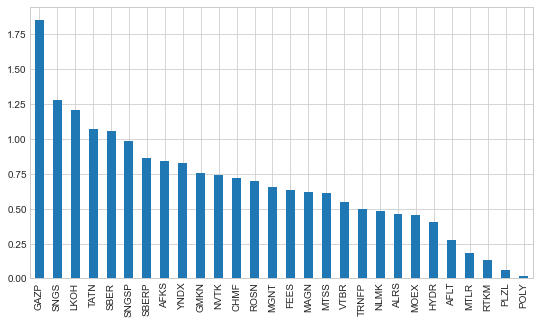

In [80]:
avg_betas = BetaCov2019.average_betas
pd.Series(avg_betas).sort_values(ascending=False).plot(kind='bar', figsize=(9, 5));

Мы можем также нарисовать все 60 бет для каждого из почти 30 активов - все эти данные есть в объекте `BetaCov2019` в атрибуте **`betas`**:

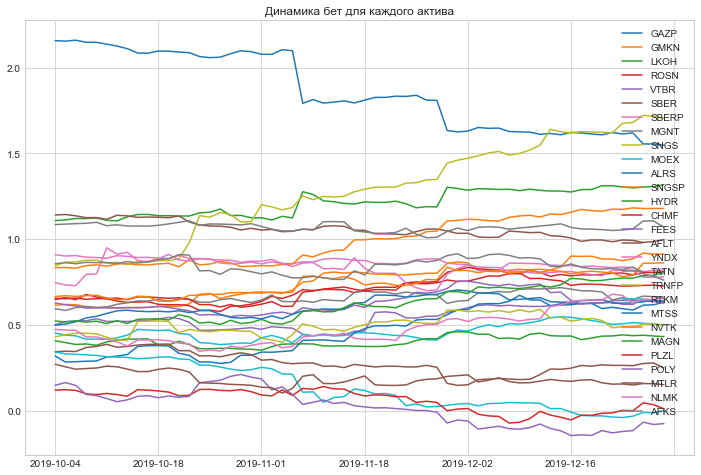

In [81]:
BetaCov2019.betas.sort_index(ascending=True).plot(title='Динамика бет для каждого актива', figsize=(12, 8));

Мы также можем посмотреть на динамику RMSE и разброс ошибки на тестовых выборках для каждого эмитента. Напомню, что ошибки считаются для прогноза доходности каждой акции по значениям фондового индекса ММВБ за соответствующий период.

Ошибка составляет от половины процента до двух с половиной процентов. Это не слишком хороший результат, но вполне приличный для линейной модели результат, поскольку дневные доходности лежат в диапазоне примерно +-6-7%, но в среднем близки к нулю. Причём надо учесть, что это ошибка на обучающей выборке - если бы мы ещё оценивали ошибку по валидационной выборке, результаты вообще могли бы выглядеть не слишком приятно. Но наша цель - скорее привести доходности к стационарному виду с помощью бет, чем подобрать идеальную модель для прогнозирования доходности каждой акции; данные по ошибкам нужны нам, чтобы просто увидеть, что линейные модели не посчитали откровенный трэш.

Модель явно не справилась с Сургутнефтегазом - но он неликвидный и, возможно, не всегда двигается вместе с рынком. Яндекс рос быстрее рынка, поэтому на нём ошибка тоже большая.

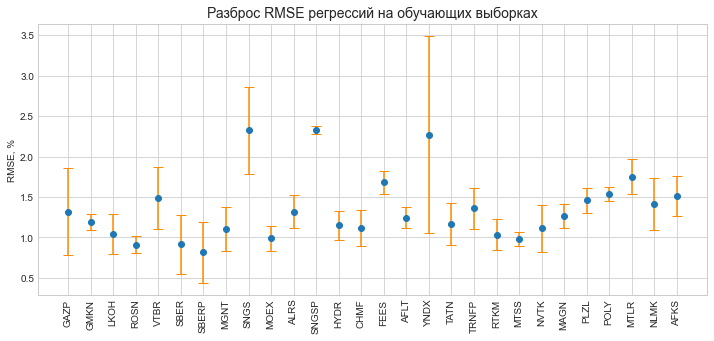

In [82]:
min_errors = BetaCov2019.RMSE.sort_index(ascending=True).min().values.ravel()*100
max_errors = BetaCov2019.RMSE.sort_index(ascending=True).max().values.ravel()*100
de = max_errors - min_errors

x = np.linspace(0, 28, 28)
mean_errors = BetaCov2019.RMSE.sort_index(ascending=True).mean().values.ravel()*100

plt.style.use('seaborn-whitegrid');
plt.figure(figsize=(12, 5));
plt.errorbar(x, mean_errors, yerr=de, fmt='o', ecolor='darkorange', capsize=5);
plt.xticks(x, sample_2019.columns.values.tolist(), rotation=90);
plt.title('Разброс RMSE регрессий на обучающих выборках', fontsize=14);
plt.ylabel('RMSE, %');

Ну и наконец, мы можем посмотреть на ковариационную матрицу, посчитанную по бетам, ради которой всё и затевалось:

In [83]:
print("Часть ковариационной матрицы, оценённой с помощью средних бет:")
BetaCov2019.mean_vcov.head(5)
print("Часть ковариационной матрицы, оценённой с помощью медианных бет:")
BetaCov2019.median_vcov.head(5)

Часть ковариационной матрицы, оценённой с помощью средних бет:


,GAZP,GMKN,LKOH,ROSN,VTBR,SBER,SBERP,MGNT,SNGS,MOEX,...,TRNFP,RTKM,MTSS,NVTK,MAGN,PLZL,POLY,MTLR,NLMK,AFKS
GAZP,0.000169,0.000069,0.000110,0.000063,0.000050,0.000096,0.000079,0.000060,0.000116,0.000042,...,0.000045,0.000012,0.000056,0.000068,0.000057,0.000005,1.568041e-06,0.000017,0.000044,0.000077
GMKN,0.000069,0.000028,0.000045,0.000026,0.000020,0.000039,0.000032,0.000024,0.000047,0.000017,...,0.000018,0.000005,0.000023,0.000028,0.000023,0.000002,6.384623e-07,0.000007,0.000018,0.000031
LKOH,0.000110,0.000045,0.000072,0.000041,0.000032,0.000063,0.000051,0.000039,0.000076,0.000027,...,0.000030,0.000008,0.000036,0.000044,0.000037,0.000003,1.022299e-06,0.000011,0.000029,0.000050
ROSN,0.000063,0.000026,0.000041,0.000024,0.000019,0.000036,0.000030,0.000022,0.000044,0.000016,...,0.000017,0.000005,0.000021,0.000025,0.000021,0.000002,5.880542e-07,0.000006,0.000016,0.000029
VTBR,0.000050,0.000020,0.000032,0.000019,0.000015,0.000028,0.000023,0.000018,0.000034,0.000012,...,0.000013,0.000004,0.000016,0.000020,0.000017,0.000002,4.607660e-07,0.000005,0.000013,0.000023


Часть ковариационной матрицы, оценённой с помощью медианных бет:


,GAZP,GMKN,LKOH,ROSN,VTBR,SBER,SBERP,MGNT,SNGS,MOEX,...,TRNFP,RTKM,MTSS,NVTK,MAGN,PLZL,POLY,MTLR,NLMK,AFKS
GAZP,0.000161,0.000071,0.000108,0.000063,0.000048,0.000093,0.000077,0.000058,0.000114,0.000040,...,0.000045,0.000008,0.000056,0.000067,0.000054,0.000008,2.198007e-06,0.000015,0.000040,0.000076
GMKN,0.000071,0.000031,0.000047,0.000028,0.000021,0.000041,0.000034,0.000025,0.000050,0.000017,...,0.000020,0.000004,0.000024,0.000029,0.000024,0.000003,9.651671e-07,0.000007,0.000017,0.000033
LKOH,0.000108,0.000047,0.000072,0.000042,0.000032,0.000062,0.000051,0.000038,0.000076,0.000027,...,0.000030,0.000005,0.000037,0.000045,0.000036,0.000005,1.469186e-06,0.000010,0.000026,0.000051
ROSN,0.000063,0.000028,0.000042,0.000024,0.000019,0.000036,0.000030,0.000022,0.000044,0.000015,...,0.000017,0.000003,0.000022,0.000026,0.000021,0.000003,8.562682e-07,0.000006,0.000015,0.000030
VTBR,0.000048,0.000021,0.000032,0.000019,0.000014,0.000028,0.000023,0.000017,0.000034,0.000012,...,0.000013,0.000002,0.000016,0.000020,0.000016,0.000002,6.522497e-07,0.000005,0.000012,0.000022


Настало время применить сделанный нами класс для оценки эффективных границ портфелей.

## 10. Построить границу эффективных портфелей на основе полученной в п. 8 ковариационной матрицы и проанализировать динамику её изменения. <a class="anchor" id="betacovmat_results"></a>

У нас в выборке 8 лет. Чтобы не возиться с кучей графиков, посчитаем эффективную границу на конец каждого года. Считать средние беты будем по 63 наблюдениям (то есть за последний в году торговый квартал), каждая бета будет оцениваться на выборке из 126 наблюдений (половина торгового года). Для оценки обычного портфеля будем использовать данные за последние полгода (126 наблюдений).

Очень интересный момент. Оказывается, автор библиотеки pyportfolioopt умножает свои ковариационные матрицы на 252 (типа аннуализированная волатильность). В документации об этом нигде толком не написано, приходится развивать навыки ясновидения.

Разрешим формировать портфели с короткими позициями - у нас в выборке есть несколько кризисных лет.

C:\Users\Vladimir\anaconda3\lib\site-packages\pypfopt\base_optimizer.py:473: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(objective_functions.portfolio_variance(new_weights, cov_matrix))
C:\Users\Vladimir\anaconda3\lib\site-packages\cvxpy\atoms\elementwise\power.py:173: RuntimeWarning: invalid value encountered in power
  return np.power(values[0], float(self.p.value))
C:\Users\Vladimir\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1267: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\Vladimir\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1267: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\Vladimir\anaconda3\lib\site-packages\pypfopt\base_optimizer.py:473: RuntimeWarning: invalid value encountered in sqrt
  sigm

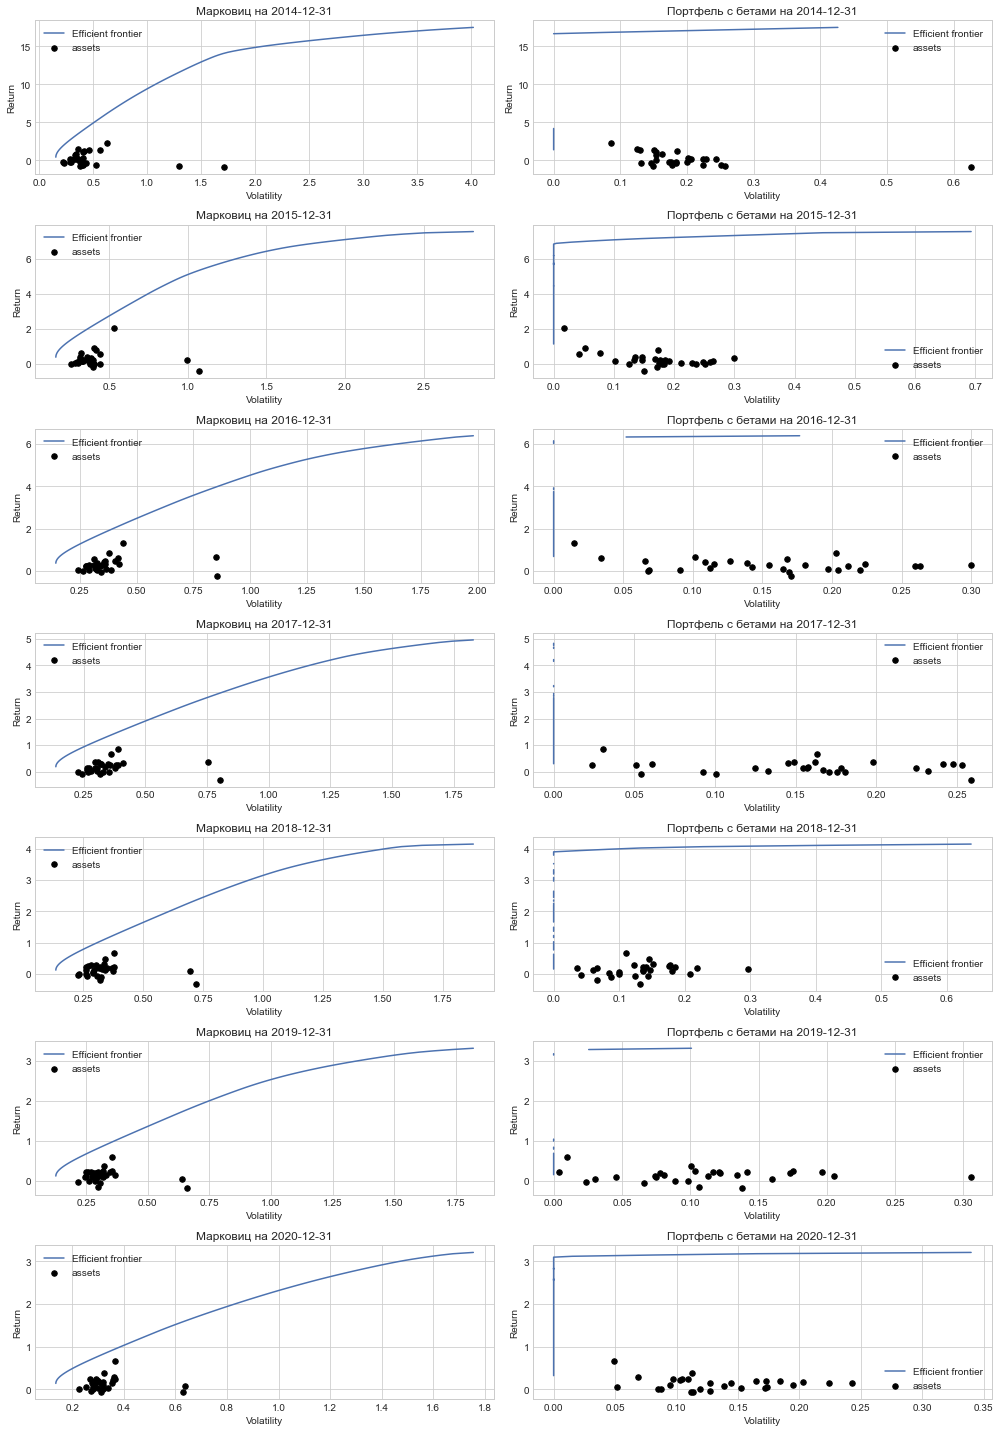

In [106]:
from pypfopt import plotting

dates_y = pd.date_range(start = '2014-06-09', end='2021-06-11', freq='Y')
# так как в выборке маловато наблюдений, заменим первую дату
dates_y

fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(14, 20));

# короткие продажи разрешены и не имеют ограничений

# years = [str(y) for y in set(rets.index.year) if str(y)!= '2017']
for i, date in enumerate(np.repeat(dates_y, 2)):
    
    period_prices = prices[prices.index<date]
    period_index = indexes[indexes.index<date].IMOEX
    period_rets = rets[rets.index < date]
    
    if i%2==0:
        # считаем обычный портфель Марковица
        mu = expected_returns.mean_historical_return(period_prices)
        #mu = expected_returns.capm_return(period_prices)
        S = risk_models.sample_cov(period_prices)
        
        axs[i//2, i%2].set_title(f"Марковиц на {date.date()}");
    else:
        # посчитаем портфель с помощью бет
        mu = expected_returns.mean_historical_return(period_prices)
        CustomCov = BetaCov(data=period_rets, 
                            index=period_index)
        
        # в 2014 году маловато наблюдений
        if str(date)=='2014-12-31 00:00:00':
            CustomCov.fit(agg_period=63, window=70)
        else:
            CustomCov.fit(agg_period=63, window=126)
        
        # умножим на 252, как это делает автор библиотеки
        # просто чтобы наши результаты были сопоставимы с обычной моделью Марковица
        mu = expected_returns.mean_historical_return(period_prices)
        S = CustomCov.mean_vcov*252
        
        axs[i//2, i%2].set_title(f"Портфель с бетами на {date.date()}");
        
        
    ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
    plotting.plot_efficient_frontier(ef, 
                                         show_assets=True, 
                                         ax=axs[i//2, i%2]);
        
plt.savefig(image_dir/'Markowitz and Beta portfolios.jpg', dpi=600, bbox_inches='tight');      

Гораздо более низкой волатильности имеется банальное объяснение. Большинство бет меньше единицы - стало быть, когда мы на их значения умножаем индекс, волатильность доходностей падает. Если сюда ещё добавить тот факт, что индекс в известной степени нивелирует шоки, связанные с отдельными эмитентами, то станет вполне понятной столь сильная разница в волатильности при применении $\beta$ для оценки оптимального портфеля.

In [18]:
rets.var().mean()
indexes.IMOEX.var()

0.00043609571686311185

0.00012725382404170016

Что и требовалось доказать: волатильность индекса существенно ниже средней волатильности по выборке, а мы ещё умножаем её на множитель, который в среднем меньше единицы:
$$
Var(market\_model\_returns_{i}) = Var(\beta_i \times index\_returns) = Var(const\times index\_returns) = const^2\times Var(index\_returns)
$$

В общем, лично я бы такой подход на практике использовать не стал: он явно недооценивает риски портфеля. Скорее подойдут какие-нибудь способы робастной оценки ковариационных матриц навроде Ледуа-Вольфа.

А что будет, если мы в оптимизатор в качестве ожидаемых доходностей будем подавать на вход средние доходности, оценённые с помощью market model?

C:\Users\Vladimir\anaconda3\lib\site-packages\pypfopt\base_optimizer.py:473: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(objective_functions.portfolio_variance(new_weights, cov_matrix))
C:\Users\Vladimir\anaconda3\lib\site-packages\cvxpy\atoms\elementwise\power.py:173: RuntimeWarning: invalid value encountered in power
  return np.power(values[0], float(self.p.value))
C:\Users\Vladimir\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1267: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\Vladimir\anaconda3\lib\site-packages\pypfopt\base_optimizer.py:473: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(objective_functions.portfolio_variance(new_weights, cov_matrix))
C:\Users\Vladimir\anaconda3\lib\site-packages\cvxpy\atoms\elementwise\power.py:173: RuntimeWarning: invalid value encountered in power
  return np.power(values

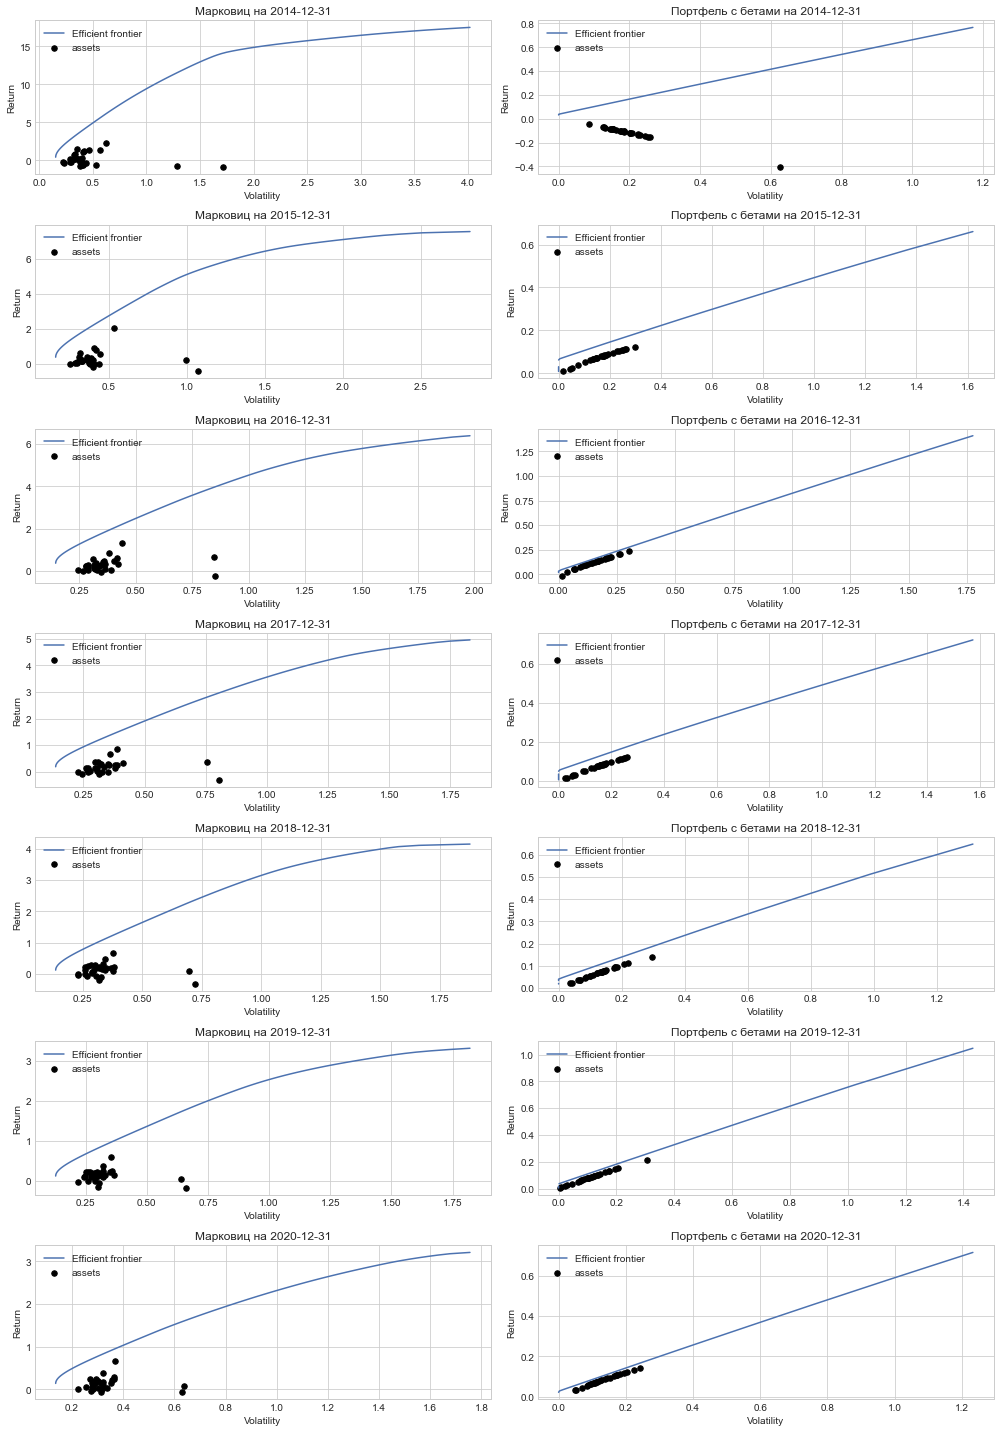

In [105]:
fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(14, 20));

# короткие продажи разрешены и не имеют ограничений

# years = [str(y) for y in set(rets.index.year) if str(y)!= '2017']
for i, date in enumerate(np.repeat(dates_y, 2)):
    
    period_prices = prices[prices.index<date]
    period_index = indexes[indexes.index<date].IMOEX
    period_rets = rets[rets.index < date]
    
    if i%2==0:
        # считаем обычный портфель Марковица
        mu = expected_returns.mean_historical_return(period_prices)
        #mu = expected_returns.capm_return(period_prices)
        S = risk_models.sample_cov(period_prices)
        
        axs[i//2, i%2].set_title(f"Марковиц на {date.date()}");
    else:
        # посчитаем портфель с помощью бет
        mu = expected_returns.mean_historical_return(period_prices)
        CustomCov = BetaCov(data=period_rets, 
                            index=period_index)
        
        # в 2014 году маловато наблюдений
        if str(date)=='2014-12-31 00:00:00':
            CustomCov.fit(agg_period=63, window=70)
        else:
            CustomCov.fit(agg_period=63, window=126)
        
        # умножим на 252, как это делает автор библиотеки
        # просто чтобы наши результаты были сопоставимы с обычной моделью Марковица
        mu = expected_returns.mean_historical_return(CustomCov.average_beta_rets, returns_data=True)
        S = CustomCov.mean_vcov*252
        
        axs[i//2, i%2].set_title(f"Портфель с бетами на {date.date()}");
        
        
    ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
    plotting.plot_efficient_frontier(ef, 
                                         show_assets=True, 
                                         ax=axs[i//2, i%2]);
        
plt.savefig(image_dir/'Markowitz and Beta portfolios.jpg', dpi=600, bbox_inches='tight');      

Получились почти прямые линии, что неудивительно. Ведь теперь любой актив - это просто индекс, умноженный на константу. Значит,
* доходность этого актива - доходность индекса, умноженная на константу
* волатильность актива -  волатильность индекса, умноженная на квадрат константы
* элементы вне диагонали ковариационной матрицы равны произведениям попарным произведениям бет конкретных активов на волатильность самого индекса.

Но, теоретически, в таком портфеле всё равно возможна диверсификация - просто теперь она зависит исключительно от размера бет. И так как у нас большинство бет близки к единице, то в конкретно нашем портфеле, если оценивать с помощью market model и ковариационную матрицу, и ожидаемые доходности, диверсификации почти не будет.

Проиллюстрируем: средняя аннуализированная доходность индекса ММВБ за 2014-2021: 0.13566500107551052.
Проиллюстрируем: средняя аннуализированное ст. откл. индекса за 2014-2021: 2.8427322846065066.
Нарисуем все ожидаемые доходности и волатильности активов за 2019 год, используя беты активов и данные индекса:


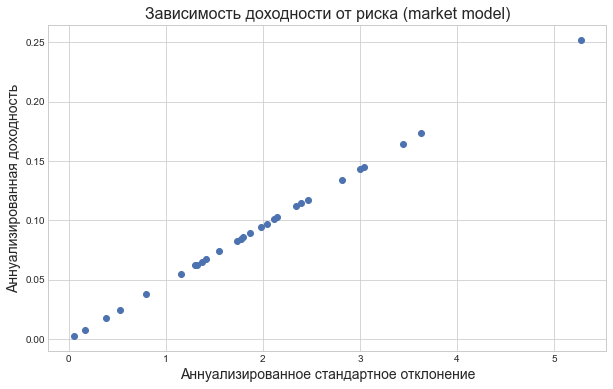

In [117]:
print(f"Проиллюстрируем: средняя аннуализированная доходность индекса ММВБ за 2014-2021: {indexes.IMOEX.mean()*252}.")
print(f"Проиллюстрируем: средняя аннуализированное ст. откл. индекса за 2014-2021: {indexes.IMOEX.std()*252}.")

print("Нарисуем все ожидаемые доходности и волатильности активов за 2019 год, используя беты активов и данные индекса:")

asset_betas = np.array(BetaCov2019.average_betas.values)
asset_returns = asset_betas * indexes.IMOEX.mean()*252
asset_volatilities = asset_betas * indexes.IMOEX.std()*252

fig, ax = plt.subplots(figsize=(10, 6));
ax.scatter(asset_volatilities, asset_returns);
ax.set_title('Зависимость доходности от риска (market model)', fontsize=16);
ax.set_xlabel('Аннуализированное стандартное отклонение', fontsize=14);
ax.set_ylabel('Аннуализированная доходность', fontsize=14);